<h3>System Constants</h3>

In [148]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares, minimize, curve_fit
from scipy.special import softmax
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.signal import find_peaks
from IPython.display import clear_output
import warnings

In [149]:
E_VBM = 3.70576
E_CBM = 10.3249
lattice_constant = 8.387
L = lattice_constant

<h3>Plots</h3>

In [150]:
def doscar_plot(base, address_list, savename, label_list, fermi_level_list):

    n = len(address_list)
    fig, axes = plt.subplots(1, n, figsize=(int(2*n),4), dpi=500, tight_layout=True, sharey=True, squeeze=False)

    for i, address in enumerate(address_list):
        
        data = pd.read_csv(base+address, delim_whitespace=True)
        energy = np.array(data["Energy"])
        DOS = np.array(data["DOS"])
        DOS /= np.max(DOS)

        axes[0][i].set_title(label_list[i])
        axes[0][i].get_xaxis().set_visible(False)
        axes[0][i].plot(DOS, energy, color=(0.2, 0.2, 0.2))
        
        #valence band maximum
        axes[0][i].fill_between([0, 1.2], E_VBM, color=(.7, 0, 0, 0.2))
        #Conduction band maximum
        axes[0][i].fill_between([0, 1.2], E_CBM, 12 , color=(0.7, 0.7, 0, 0.2))
        #Fermi Level
        axes[0][i].hlines(fermi_level_list[i], 0, 1, color="k",linewidth=1, linestyle='dashed')
        axes[0][i].text(1.1, fermi_level_list[i], "$E_{f}$", color='k', va='center', ha='center')

        axes[0][i].set_ylim(0, 12)
        axes[0][i].set_xlim(0, 1.2)

    axes[0][0].set_ylabel("Energy (eV)")
    plt.savefig(savename, bbox_inches="tight")
    plt.show()
    
    
    
def strain_tensor_bar(eigenvalues, charge_states, pg_list, savename):
    
    bar_spacing = 0.85
    group_spacing = 3.5
    
    n = len(eigenvalues) // 3
    xpos = []
    for i in range(n):
        for j in range(3):
            xpos.append(group_spacing*i+(j*bar_spacing))
    
            
    fig, ax = plt.subplots(figsize=(int(2*n),3), dpi=300)
    fig.tight_layout()
    max_value = np.max(eigenvalues)
    min_value = np.min(eigenvalues)
    if min_value > 0 :
        min_value = 0
    
    text_offset = (max_value - min_value)*0.1
    
    for i in range(n):
        point_group = str(pg_list[i])
        first_letter = point_group[0]
        subscript = point_group[1:]
        pg_string = "${"+first_letter+"}_{"+subscript+"}$"
        eigvals = eigenvalues[3*i:3*i+3]
        extremal_sign = np.sign(eigvals)[np.argmax(np.abs(eigvals))]
        text_height = np.max(np.abs(eigvals))*extremal_sign+text_offset*extremal_sign
        plt.text(xpos[3*i+1], text_height, pg_string, ha='center')
        
    # Save the chart so we can loop through the bars below.
    bars = ax.bar(x=xpos, height=eigenvalues, color="#FFAA33")      
    
    plt.ylim(min_value-(2*text_offset), max_value+(2*text_offset))

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)


    ax.set_title("Strain Tensor Eigenvalues")
    ax.plot([-bar_spacing, max(xpos)+bar_spacing], [0,0], color='k')
    ax.set_xticks(xpos[1::3])
    ax.set_xticklabels(charge_states)
    ax.set_xlabel("Charge State")
    ax.set_xlim(-bar_spacing, max(xpos)+bar_spacing)
    plt.savefig(savename+"_bar.pdf", bbox_inches='tight')
    plt.show()  
    plt.close()
    
    
    


In [151]:
def displacement_plot(atomic_pos, ref_pos, num_Mg, num_O, arrow_length=4):
    O_color = (.7, 0, 0, 0.8)
    Mg_color = (0.7, 0.7, 0, 0.8)
    color = [Mg_color]*num_Mg + [O_color]*num_O
    dx, dy, dz = displacement_field(atomic_pos, ref_pos)
    ax = plt.figure(figsize=(3,3), dpi=300).add_subplot(projection='3d')
    ax.quiver(ref_pos[0], ref_pos[1], ref_pos[2], dx, dy, dz, normalize=False, length=arrow_length, color='k')
    ax.scatter(ref_pos[0], ref_pos[1], ref_pos[2], c=color)
    plt.show()
    plt.close()

<h3>Strain Tensor Calculation</h3>

In [152]:
#return the minimum image of a vector under periodic boundary conditions
def minimum_image(x):
    x[x < - (L * 0.5)] = x[x < - (L * 0.5)] + L
    x[x >=  (L * 0.5)] = x[x >=  (L * 0.5)] - L
    return x

#return the periodic difference from a vector field to a point
def difference_from_point(p, vector_field):
    dx = minimum_image(p[0] - vector_field[0])
    dy = minimum_image(p[1] - vector_field[1])
    dz = minimum_image(p[2] - vector_field[2])
    return dx, dy, dz

#return the periodic difference of two vectors
def difference_vector(u, v):
    return minimum_image(u - v)
       
#return tuple of displacement vectors associated with each atomic position
def displacement_field(atomic_pos, ref_pos):
    dx = difference_vector(atomic_pos[0], ref_pos[0])
    dy = difference_vector(atomic_pos[1], ref_pos[1])
    dz = difference_vector(atomic_pos[2], ref_pos[2])
    return dx, dy, dz

#calculate the periodic distance between points in space
def periodic_distance(x, ref_pos):
    dx, dy, dz = difference_from_point(x, ref_pos)
    return np.sqrt((dx**2) + (dy**2) + (dz**2))
    
#find the indices associated with the nearest neighbors of the defect site
def nearest_neighbor_indices(defect_pos, ref_pos):
    distance = periodic_distance(defect_pos, ref_pos)
    sorted_indices = np.argsort(distance)
    num_zeros = np.sum(distance  == 0.)
    num_nearest_neighbors = np.sum(distance == distance[sorted_indices][num_zeros:][0])
    return sorted_indices[num_zeros:num_nearest_neighbors+num_zeros]

#get the index associated with a particular position in the reference
def get_atomic_index(atom_pos, ref_pos):
    distance = periodic_distance(atom_pos, ref_pos)
    return np.argwhere(distance == 0.)[0][0]       

#generate the displacement grdient at the defect site with reference to the unrelaxed crystal
def generate_displacement_gradient(defect_pos, atomic_pos, ref_pos):
    
    nn_indices = nearest_neighbor_indices(defect_pos, ref_pos)
    disp_field = displacement_field(atomic_pos, ref_pos)
    
    #generate jacobian of displacement field at defect site
    jac_list = []
    for dim in range(3):
        row_vec = np.zeros(3)
        for index in nn_indices:
            
            q = np.array([ref_pos[0][index], ref_pos[1][index], ref_pos[2][index]]) - defect_pos
            q = minimum_image(q)
            opp_index = get_atomic_index(minimum_image(defect_pos - q), ref_pos)
            h = np.sqrt(np.dot(q, q))
            q /= h
            dudq =  0.5 * (disp_field[dim][index] - disp_field[dim][opp_index]) / h
            row_vec += dudq * q
        
        jac_list.append(row_vec / len(nn_indices))

    jacobian = np.vstack(jac_list)
    return jacobian 



#generate the symmetric strain tensor at the defect site with reference to the unrelaxed crystal
def generate_strain_tensor(defect_pos, atomic_pos, ref_pos):       

    jacobian = generate_displacement_gradient(defect_pos, atomic_pos, ref_pos)

    #generate strain tensor from jacobian
    strain_tensor = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            strain_tensor[i, j] = 0.5 * (jacobian[i,j] + jacobian[j, i])
    return strain_tensor

<h3>Defect Edge Length</h3>

In [153]:
#generate defect complex distance matrix
def distance_matrix(pos, defect_pos):
    pos = difference_from_point(defect_pos, pos)
    n = pos[0].shape[0]
    dist_mat = np.zeros((n,n), dtype=np.float64)
    for i in range(n):
        for j in range(i+1, n):
            d = np.array([pos[0][i], pos[1][i], pos[2][i]]) - np.array([pos[0][j], pos[1][j], pos[2][j]])
            dist = np.sqrt(np.dot(d, d))
            dist_mat[i, j] = dist
            dist_mat[j, i] = dist
    return dist_mat
      
#calculate the average nearest neighbor distance
def nearest_neighbor_distance(defect_pos, ref_pos, atomic_pos):
    nn_indices = nearest_neighbor_indices(defect_pos, ref_pos)
    nn_pos = atomic_pos[0][nn_indices], atomic_pos[1][nn_indices], atomic_pos[2][nn_indices]
    test = ref_pos[0][nn_indices], ref_pos[1][nn_indices], ref_pos[2][nn_indices]
    distance = np.around(distance_matrix(nn_pos, defect_pos), 3).flatten()
    sorted_indices = np.argsort(distance)
    num_zeros = np.sum(distance  == 0.)
    num_edges = 24
    avg_dist = np.mean(distance[sorted_indices[num_zeros:num_edges+num_zeros]])
    return avg_dist

<h3>Energy Model</h3>

In [154]:
#return the energies of the defect trapped states
def defect_state_energies(address, E_VBM, E_CBM):
    data = pd.read_csv(address, delim_whitespace=True)
    dos = np.array(data["DOS"])
    energy = np.array(data["Energy"])
    band_gap_indices = (energy > E_VBM) * (energy < E_CBM)
    band_gap_dos = dos[band_gap_indices]
    band_gap_energy =  energy[band_gap_indices]
    peaks, properties = find_peaks(band_gap_dos, distance=12)
    return band_gap_energy[peaks]

<h3>MO Diagrams</h3>

In [155]:
length = 1
def singlet(ax, xval, energy, color='k', filled=False):
    ax.plot([xval-0.5*length, xval+0.5*length], [energy, energy], linewidth=2, c=color, alpha=0.5)
    if filled:
        ax.arrow(xval+0.2*length, energy-0.5*length, 0, length*1.5, width=0.1, color='k', length_includes_head=True)
        ax.arrow(xval-0.2*length, energy+0.5*length, 0,-length*1.5,  width=0.1, color='k', length_includes_head=True)
        
def doublet(ax, xval, energy, color='k', filling=[False, False]):
    singlet(ax, xval+0.75*length, energy[0], color, filled=filling[0])
    singlet(ax, xval-0.75*length, energy[1], color, filled=filling[1])
    
def triplet(ax, xval, energy, color='k', filling=[False, False, False]):
    singlet(ax, xval-1.5*length, energy[0], color , filled=filling[0])
    singlet(ax, xval, energy[1], color , filled=filling[1])
    singlet(ax, xval+1.5*length, energy[2], color , filled=filling[2])

In [156]:
from pymatgen.symmetry.analyzer import PointGroupAnalyzer
from pymatgen.core.structure import Molecule

def point_group(atomic_pos, defect_pos):
    pos = difference_from_point(defect_pos, atomic_pos)
    pos_list = []
    n = len(pos[0])
    for i in range(n):
        pos_list.append(np.array([pos[0][i], pos[1][i], pos[2][i]]))
    m = Molecule(["Mg"]*n, pos_list)
    pg =  PointGroupAnalyzer(m).get_pointgroup()
    return pg

In [157]:
def stereogram(pos):
    #normalize each row
    rows, cols = pos.shape
    for row in range(rows):
        pos[row, :] =  pos[row, :]  / np.sqrt(np.dot(pos[row, :], pos[row, :]))
    
    fig, ax = plt.subplots(dpi=500, subplot_kw={'projection': 'polar'})
    
    for row in range(rows):
        z = pos[row, 2]
        s = np.sign(z)
        #northern hemisphere
        if s == 1:
            t = (1/(z+1))
            x = t*pos[row, 0]
            y = t*pos[row, 1]
            r = np.sqrt((x**2) + (y**2))
            theta = np.arctan(y/x)
            ax.scatter([theta], [r], color='k', s=10)
        #southern hemisphere
        elif s == -1:
            t = (1/(1-z))
            x = t*pos[row, 0]
            y = t*pos[row, 1]  
            r = np.sqrt((x**2) + (y**2))
            theta = np.arctan(y/x)
            ax.scatter([theta], [r], color='k' , facecolors='none', s=40)
        elif s == 0:
            x = pos[row, 0]
            y = pos[row, 1]
            theta = np.arctan(y/x)
            print(theta)
            ax.plot([theta, theta], [0, 1], color='k')
            ax.plot([np.pi+theta, np.pi+theta], [0, 1], color='k')

    plt.show()
    plt.close()

<h3>Oxygen Vacancy</h3>

Both the density of states and atomic displacement information was calculated with an HSE calculation using symmetry.

$$ 
\begin{bmatrix} 
E_s           & \frac{V}{d^2} & \frac{V}{2 d^2} & \frac{V}{d^2} & \frac{V}{d^2} & \frac{V}{d^2}\\
\frac{V}{d^2} & E_s           & \frac{V}{d^2} & \frac{V}{2 d^2} & \frac{V}{d^2} & \frac{V}{d^2}\\
\frac{V}{2 d^2} & \frac{V}{d^2} & E_s           & \frac{V}{d^2} & \frac{V}{d^2} & \frac{V}{d^2}\\
\frac{V}{d^2} & \frac{V}{2 d^2} & \frac{V}{d^2} & E_s           & \frac{V}{d^2} & \frac{V}{d^2}\\
\frac{V}{d^2} & \frac{V}{d^2} & \frac{V}{d^2} & \frac{V}{d^2} & E_s           & \frac{V}{2 d^2}\\
\frac{V}{d^2} & \frac{V}{d^2} & \frac{V}{d^2} & \frac{V}{d^2} & \frac{V}{2 d^2} & E_s      
\end{bmatrix}
$$

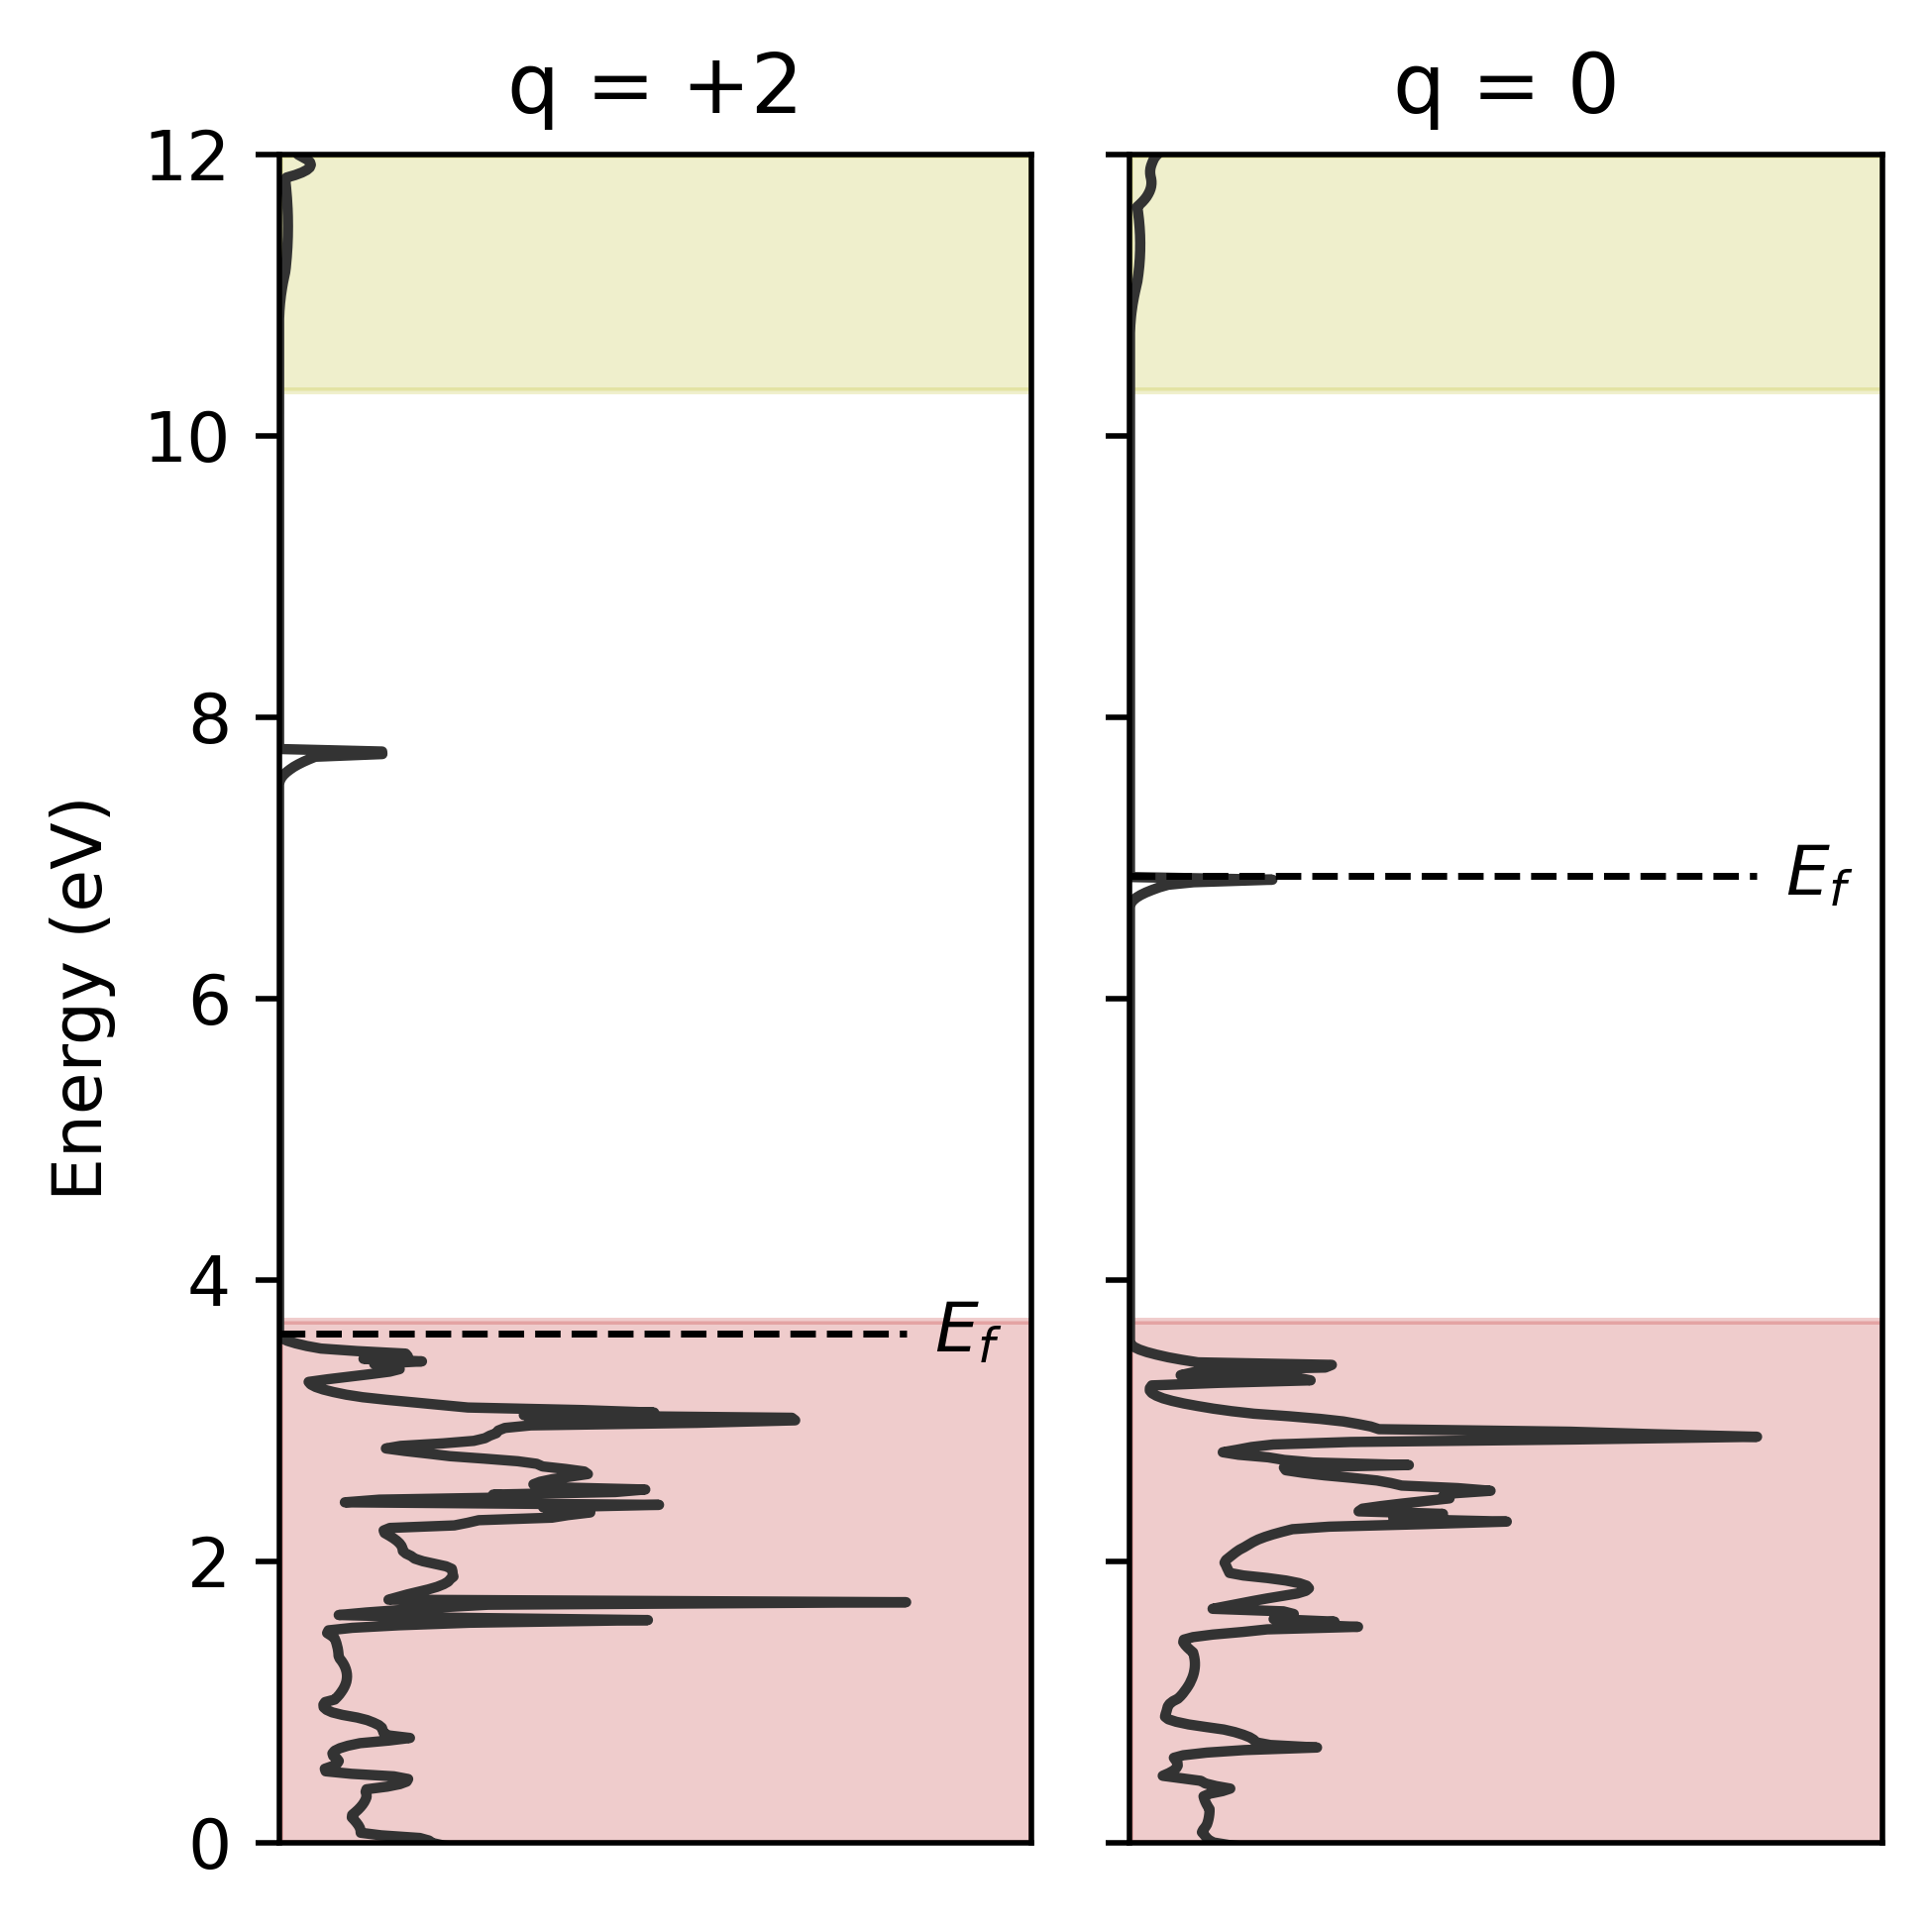

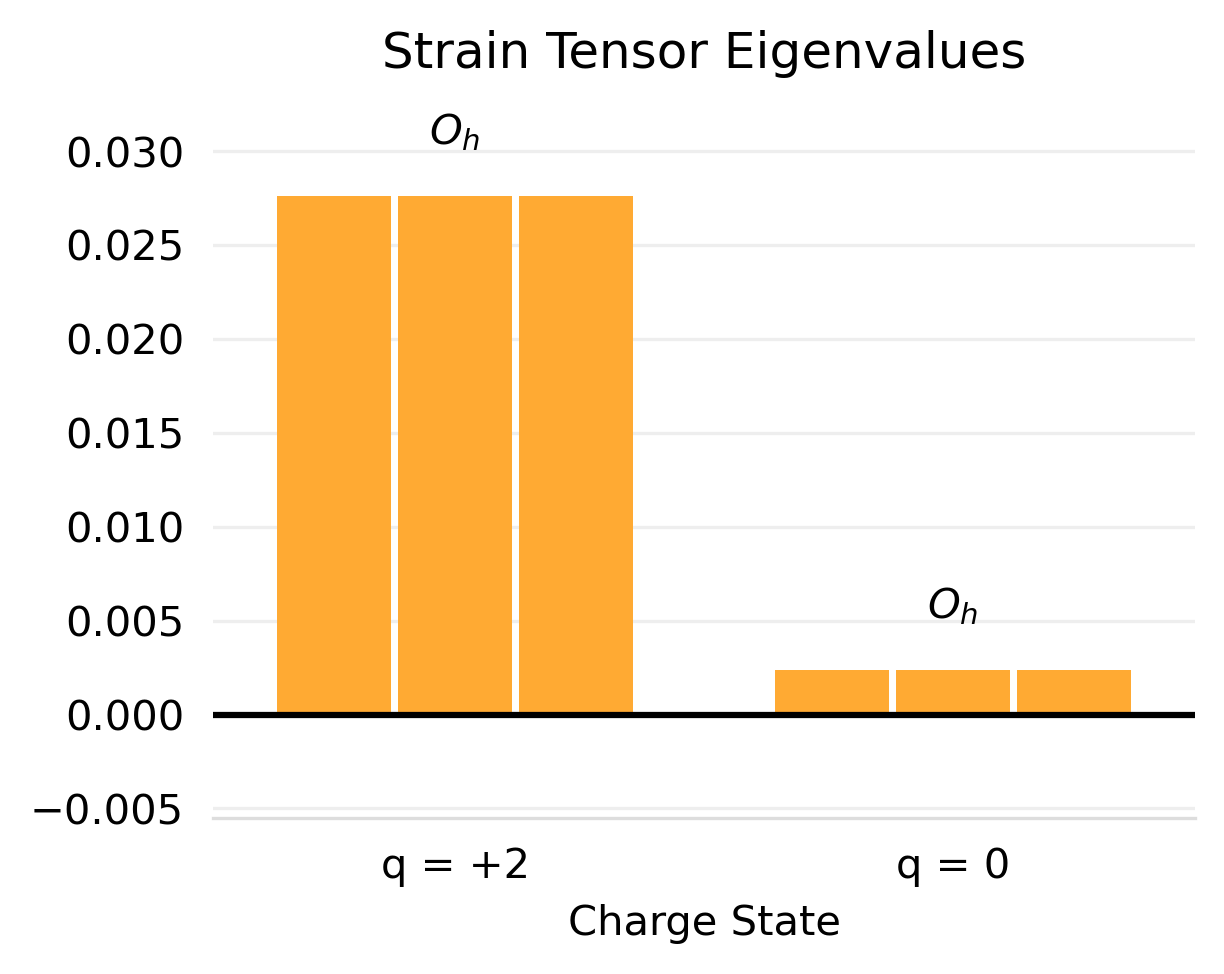

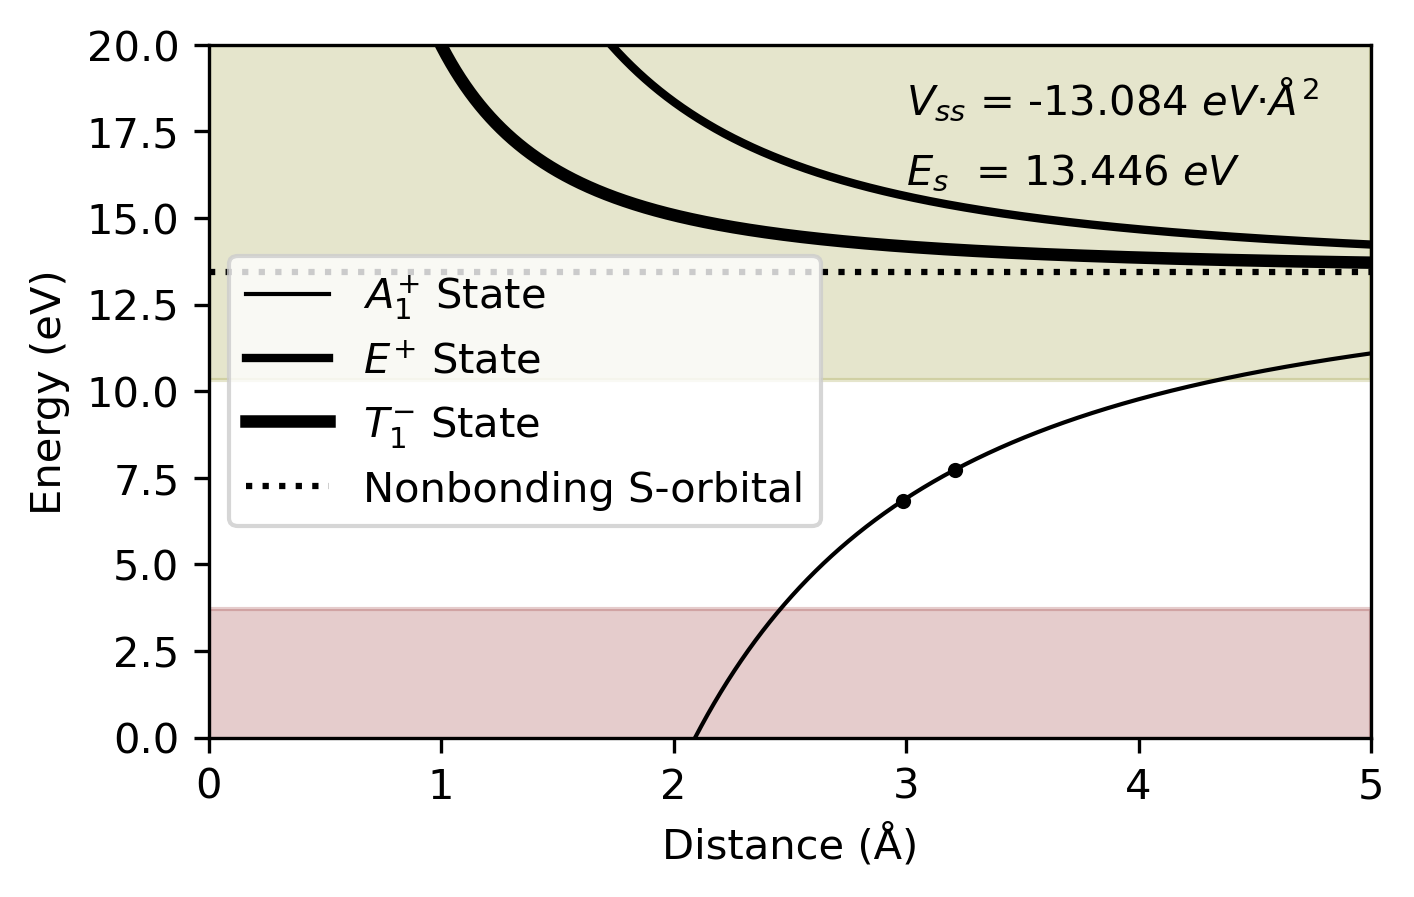

In [158]:
def O_Vacancy_Hamiltonian(d, Es, Vss):
    x = (1/d)**2
    d1 = 0.5
    H =  np.array([[      Es,    Vss*x, d1*Vss*x,   Vss*x,     Vss*x,    Vss*x], 
                   [   Vss*x,       Es,    Vss*x, d1*Vss*x,    Vss*x,    Vss*x], 
                   [d1*Vss*x,    Vss*x,       Es,    Vss*x,    Vss*x,    Vss*x], 
                   [   Vss*x, d1*Vss*x,    Vss*x,       Es,    Vss*x,    Vss*x], 
                   [   Vss*x,    Vss*x,    Vss*x,    Vss*x,       Es, d1*Vss*x], 
                   [   Vss*x,    Vss*x,    Vss*x,    Vss*x, d1*Vss*x,       Es]], dtype=np.float64)
    return H

def hamiltonian_energies(d, Es, Vss):
    H = O_Vacancy_Hamiltonian(d, Es, Vss)
    energies, eigstates = np.linalg.eig(H)
    energies, eigstates = np.around(energies.real, 8), np.around(eigstates.real, 8)
    indices = np.argsort(energies)
    energies, eigstates = energies[indices], eigstates[:, indices]
    unique_energies = np.unique(energies)
    energy_dict = dict()
    for energy in unique_energies:
        u_indices = np.argwhere(energy == energies).flatten()
        energy_dict[energy] = eigstates[:, u_indices]
    return energy_dict


def singlet_eigen_energy(dlist, Es, Vss):
    energy_list = np.zeros_like(dlist)
    for i, d in enumerate(dlist):
        energy_dict = hamiltonian_energies(d, Es, Vss)
        for energy, eigstates in energy_dict.items():
            if eigstates.shape[1] == 1:
                energy_list[i] = energy
    return energy_list
        
    
def doublet_eigen_energy(dlist, Es, Vss):
    energy_list = np.zeros_like(dlist)
    for i, d in enumerate(dlist):
        energy_dict = hamiltonian_energies(d, Es, Vss)
        for energy, eigstates in energy_dict.items():
            if eigstates.shape[1] == 2:
                energy_list[i] = energy
    return energy_list

def triplet_eigen_energy(dlist, Es, Vss):
    energy_list = np.zeros_like(dlist)
    for i, d in enumerate(dlist):
        energy_dict = hamiltonian_energies(d, Es, Vss)
        for energy, eigstates in energy_dict.items():
            if eigstates.shape[1] == 3:
                energy_list[i] = energy
    return energy_list


        

#Density of States PLots
base = "../DFT_Data/Sym/Oxygen_Vacancy/DOS/"
address_list = [ "q+2",   "q0"] 
savename = "O_Vacancy_DOS.pdf"
label_list = ["q = +2", "q = 0"]
fermi_level_list = [3.62, 6.87]
doscar_plot(base, address_list, savename, label_list, fermi_level_list)

#Atomic Positions
reference = pd.read_csv("../DFT_Data/Sym/Oxygen_Vacancy/POS/reference", delim_whitespace=True)
qplus2_pos = pd.read_csv("../DFT_Data/Sym/Oxygen_Vacancy/POS/q+2", delim_whitespace=True)
q0_pos = pd.read_csv("../DFT_Data/Sym/Oxygen_Vacancy/POS/q0", delim_whitespace=True)

defect_pos = lattice_constant*np.array([0.50, 0.750, 0.50])
defect_index = np.argwhere((np.array(reference["X"])==0.50)*(np.array(reference["Y"])==0.750)*(np.array(reference["Z"])==0.50))
pos_list = [qplus2_pos, q0_pos]
ref_pos = (lattice_constant*np.array(reference["X"]), 
           lattice_constant*np.array(reference["Y"]), 
           lattice_constant*np.array(reference["Z"]))

strain_eigenvalues = []
avg_edge_lengths = []
energy_list = []
pg_list = []
for i, pos in enumerate(pos_list):
    
    
    atomic_pos = (lattice_constant*np.array(pos["X"]), 
                  lattice_constant*np.array(pos["Y"]), 
                  lattice_constant*np.array(pos["Z"]))
    
    #print(label_list[i])
    #displacement_plot(atomic_pos, ref_pos, 32, 31)
    
    #strain calculations
    strain_tensor = generate_strain_tensor(defect_pos, atomic_pos, ref_pos)
    strain_eigenvalues += list(np.linalg.eigvals(strain_tensor))
    
    #distance calculations
    avg_edge_lengths.append(nearest_neighbor_distance(defect_pos, ref_pos, atomic_pos))
    
    #energy calculations
    energy_list.append(defect_state_energies(base+address_list[i], 4.5, 10)[0])
    
    nn_indices = nearest_neighbor_indices(defect_pos, ref_pos)
    atomic_pos = atomic_pos[0][nn_indices], atomic_pos[1][nn_indices], atomic_pos[2][nn_indices]
    pg_list.append(point_group(atomic_pos, defect_pos))
    
    
    
avg_edge_lengths = np.array(avg_edge_lengths)
energy_list = np.array(energy_list)
strain_tensor_bar(strain_eigenvalues, label_list, pg_list, "O_vacancy")
    
    
### fitting the tight binding energy model ###
popt, pcov, infodict, mesg, ier = curve_fit(singlet_eigen_energy, avg_edge_lengths, energy_list, p0=[13, -10], full_output=True)
Es, Vss = popt

dlist = np.linspace(0.3, 5, 10000)
xlist = (1/dlist)**2

a1plus_energy_list = singlet_eigen_energy(dlist, Es, Vss)
eplus_energy_list =  doublet_eigen_energy(dlist, Es, Vss)
t1minus_energy_list =  triplet_eigen_energy(dlist, Es, Vss)
  
plt.figure(figsize=(5, 3), dpi=300)
plt.plot(dlist, a1plus_energy_list, label=r"$A^{+}_{1}$ State", c='k', linewidth=1)
plt.plot(dlist, eplus_energy_list, label=r"$E^{+}$ State", c='k', linewidth=2)
plt.plot(dlist, t1minus_energy_list, label=r"$T^{-}_{1}$ State", c='k', linewidth=3)
plt.plot([0, max(dlist)], [Es, Es], label="Nonbonding S-orbital", c='k', linestyle='dotted')
plt.fill_between([0, 5], -5, E_VBM, color=(0.5, 0, 0, 0.2))
plt.fill_between([0, 5], E_CBM, 20, color=(0.5, 0.5, 0, 0.2))
plt.scatter(avg_edge_lengths, energy_list, c='k', s=7)
plt.text(3, 16, r"$E_s$  = {E:.3f} $eV$".format(E = Es))
plt.text(3, 18, r"$V_{ss}$" + r" = {v:.3f} $eV · Å^2$ ".format(v=Vss))
plt.legend() 
plt.xlabel("Distance (Å)")
plt.ylabel("Energy (eV)")
plt.xlim(0, 5)
plt.ylim(0, 20)
plt.savefig("O_Vacancy_energy.pdf", bbox_inches="tight")
plt.show()

oxygen_vacancy_energies = energy_list
oxygen_vacancy_dist = avg_edge_lengths

<h1>Magnesium Antisite</h1>

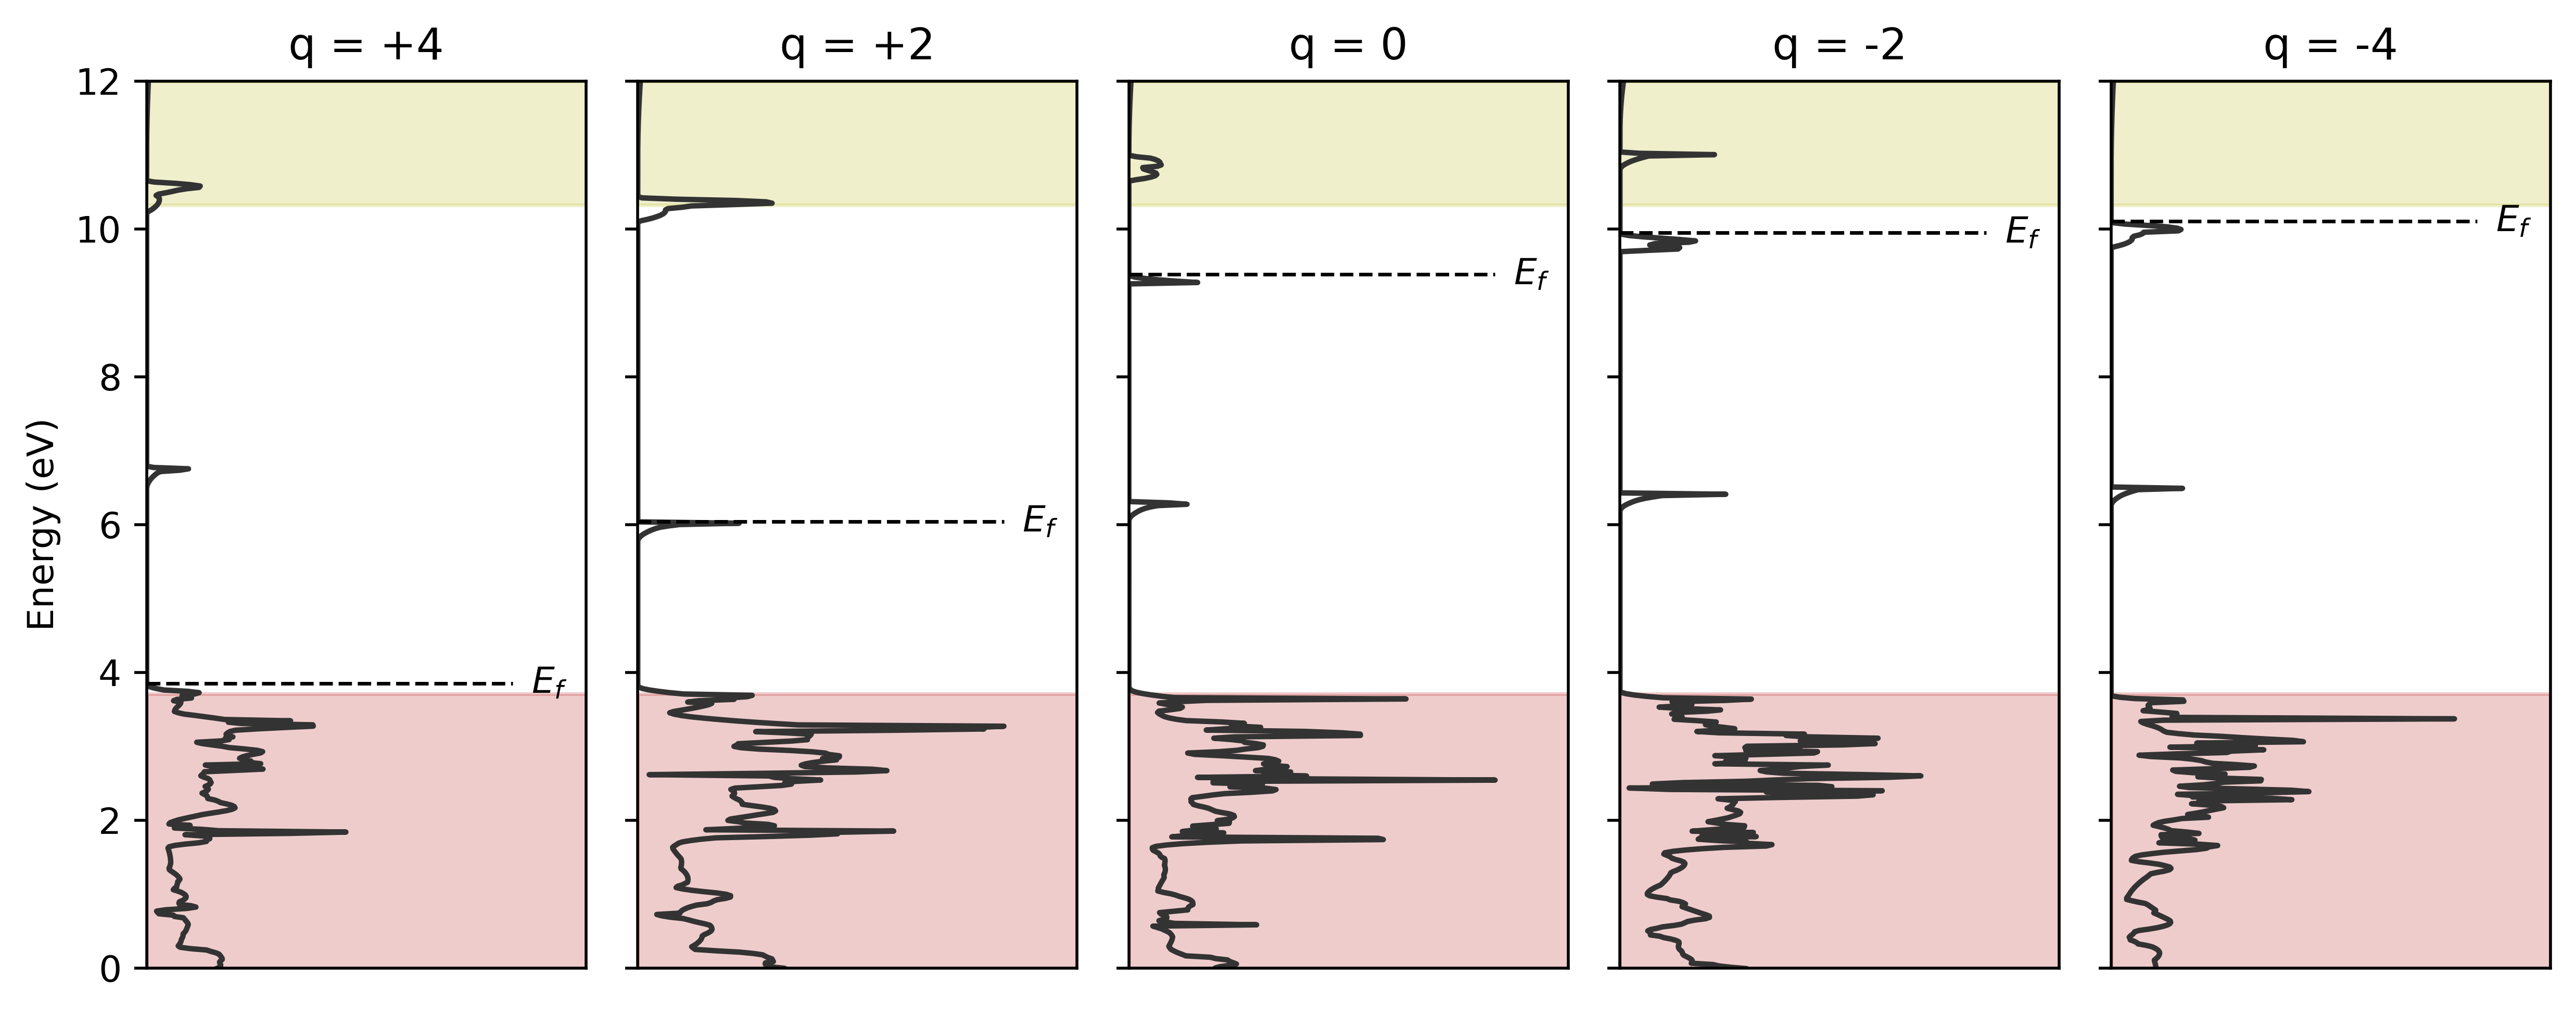

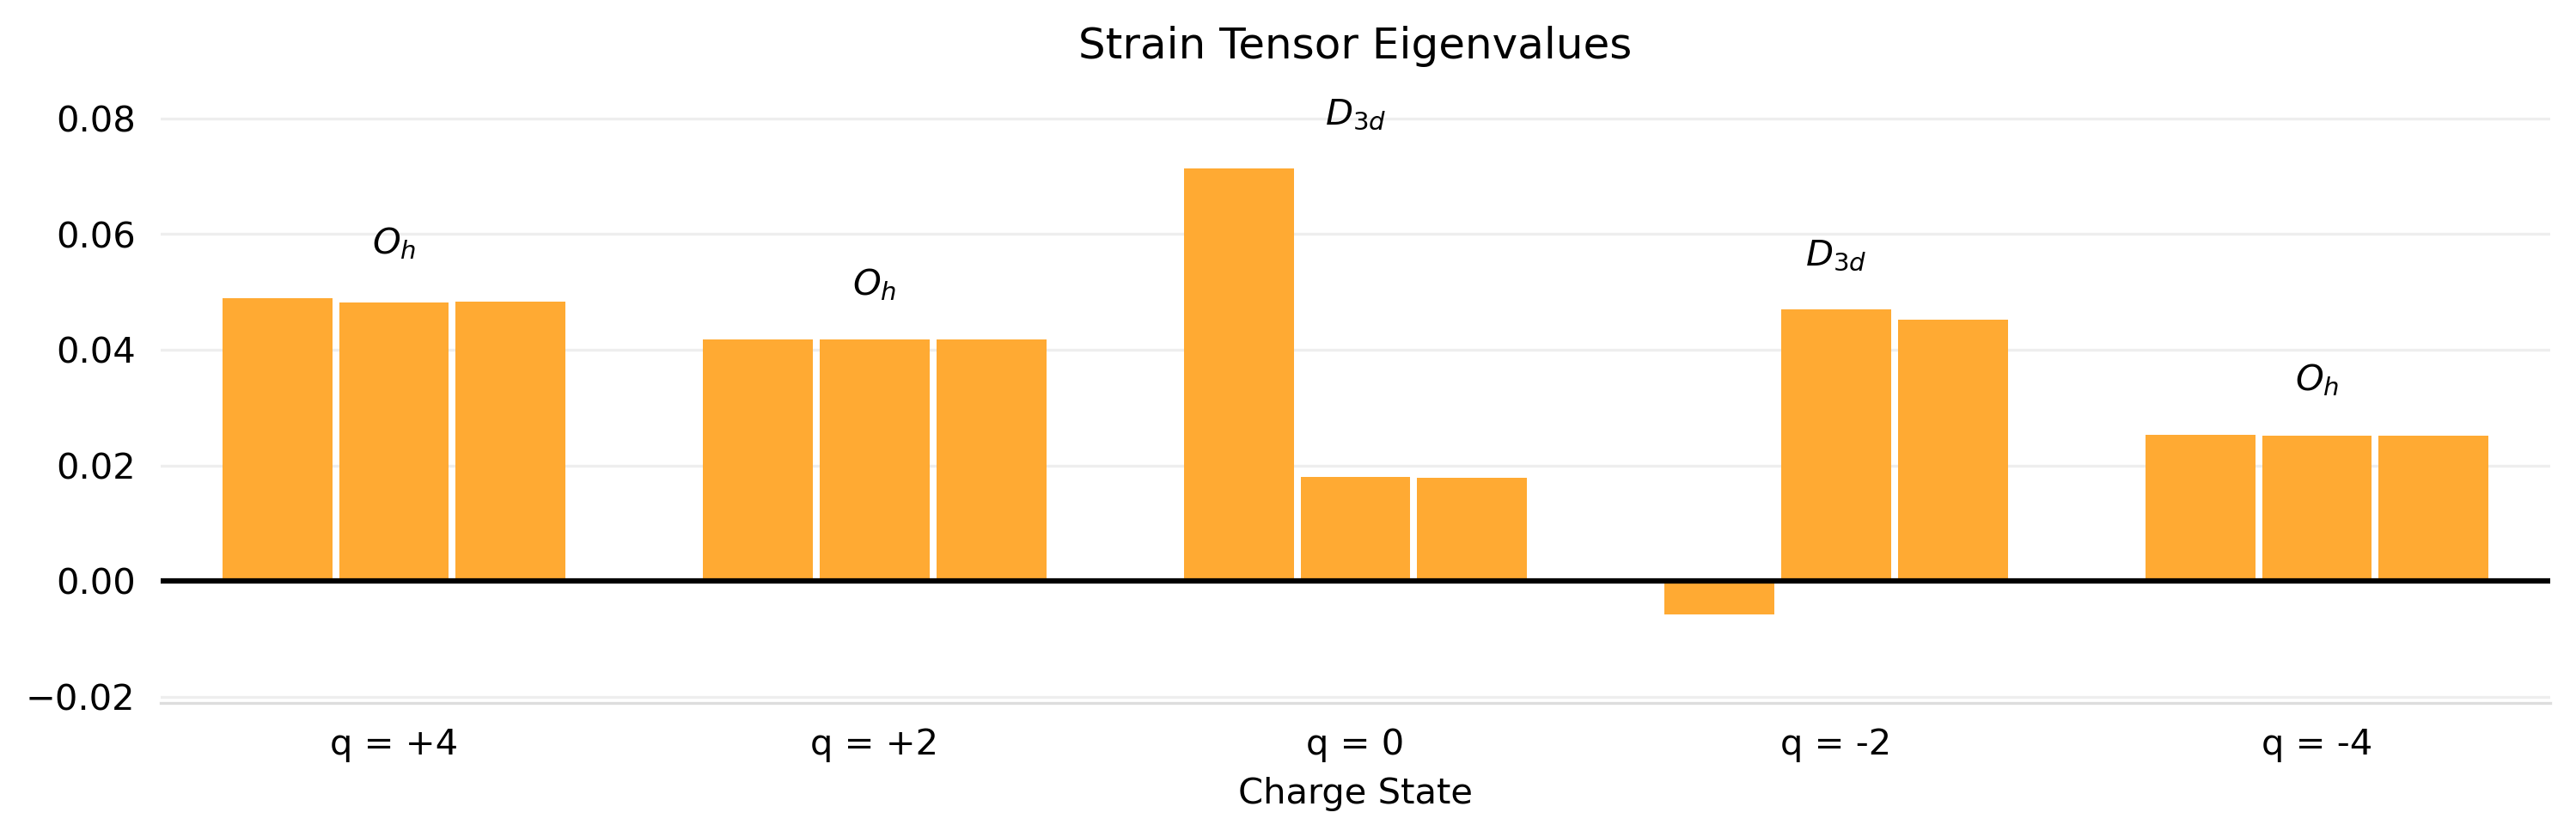

In [169]:
warnings.filterwarnings('ignore')
def a1plus_bond_sym(vec):
    if np.any(np.abs(np.std(vec[6:])/np.mean(vec[6:])) > 1):
        return False
    if np.any(np.abs(vec[1:4]) > 0.1):
        return False
    if (np.sign(vec[0]) != np.sign(vec[-1])):
        return False
    return True

def a1plus_antibond_sym(vec):
    if np.any(np.abs(np.std(vec[6:])/np.mean(vec[6:])) > 1):
        return False
    if np.any(np.abs(vec[1:4]) > 0.1):
        return False
    if (np.sign(vec[0]) == np.sign(vec[-1])):
        return False
    return True

def e_sym(vec):
    if np.all(np.abs(vec[:4]) < 0.1):
        return True
    else:
        return False

def t1minus_bond_sym(vec):
    if np.sign(vec[4]) == np.sign(vec[6]) and np.abs(vec[4]) > 0.0001 and np.abs(vec[6]) > 0.0001:
        return False
    if np.sign(vec[5]) == np.sign(vec[7]) and np.abs(vec[5]) > 0.0001 and np.abs(vec[7]) > 0.0001:
        return False
    if np.sign(vec[8]) == np.sign(vec[9]) and np.abs(vec[8]) > 0.0001 and np.abs(vec[9]) > 0.0001:
        return False
    if np.sign(vec[1]) == np.sign(vec[4]) and np.abs(vec[1]) > 0.0001 and np.abs(vec[4]) > 0.0001:
        return False
    if np.sign(vec[2]) == np.sign(vec[5]) and np.abs(vec[2]) > 0.0001 and np.abs(vec[5]) > 0.0001:
        return False
    if np.sign(vec[3]) == np.sign(vec[8]) and np.abs(vec[3]) > 0.0001 and np.abs(vec[8]) > 0.0001:
        return False
    return True

def t1minus_antibond_sym(vec):
    if np.sign(vec[4]) == np.sign(vec[6]) and np.abs(vec[4]) > 0.0001 and np.abs(vec[6]) > 0.0001:
        return False
    if np.sign(vec[5]) == np.sign(vec[7]) and np.abs(vec[5]) > 0.0001 and np.abs(vec[7]) > 0.0001:
        return False
    if np.sign(vec[8]) == np.sign(vec[9]) and np.abs(vec[8]) > 0.0001 and np.abs(vec[9]) > 0.0001:
        return False
    if np.sign(vec[1]) != np.sign(vec[4]) and np.abs(vec[1]) > 0.0001 and np.abs(vec[4]) > 0.0001:
        return False
    if np.sign(vec[2]) != np.sign(vec[5]) and np.abs(vec[2]) > 0.0001 and np.abs(vec[5]) > 0.0001:
        return False
    if np.sign(vec[3]) != np.sign(vec[8]) and np.abs(vec[3]) > 0.0001 and np.abs(vec[8]) > 0.0001:
        return False
    return True

def symmetric_distance_matrix(d):
    a = 2./np.sqrt(2)
    b = 1./np.sqrt(2)
    dist_mat = np.array([[ 0., b*d, b*d, b*d, b*d, b*d, b*d],
                         [ 0.,  0.,   d, a*d,   d,   d,   d],
                         [ 0.,  0.,  0.,   d, a*d,   d,   d],
                         [ 0.,  0.,  0.,  0.,   d,   d,   d],
                         [ 0.,  0.,  0.,  0.,  0.,   d,   d],
                         [ 0.,  0.,  0.,  0.,  0.,  0., a*d],
                         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=np.float64)
    dist_mat += dist_mat.T
    return dist_mat

def symmetric_sp_angle():
    a = np.array([[0., -1., 0., 1., 0., 0., 0.],
                  [0., 0.,-1., 0.,  1., 0., 0.],
                  [0., 0., 0., 0.,  0.,-1., 1.]])
    return a


def Mg_Antisite_Hamiltonian(dist_mat, sp_proj, Es, Vss, Ep, Vsp, Vm):
    x = (1/dist_mat)**2
    H = np.array([[Es+Vm,    0,    0,    0,                 x[0,1]*Vss,              x[0,2]*Vss,              x[0,3]*Vss,              x[0,4]*Vss,              x[0,5]*Vss,              x[0,6]*Vss],                        
                  [    0,   Ep,    0,    0,    sp_proj[0,1]*x[0,1]*Vsp, sp_proj[0,2]*x[0,2]*Vsp, sp_proj[0,3]*x[0,3]*Vsp, sp_proj[0,4]*x[0,4]*Vsp, sp_proj[0,5]*x[0,5]*Vsp, sp_proj[0,6]*x[0,6]*Vsp],               
                  [    0,    0,   Ep,    0,    sp_proj[1,1]*x[0,1]*Vsp, sp_proj[1,2]*x[0,2]*Vsp, sp_proj[1,3]*x[0,3]*Vsp, sp_proj[1,4]*x[0,4]*Vsp, sp_proj[1,5]*x[0,5]*Vsp, sp_proj[1,6]*x[0,6]*Vsp],
                  [    0,    0,    0,   Ep,    sp_proj[2,1]*x[0,1]*Vsp, sp_proj[2,2]*x[0,2]*Vsp, sp_proj[2,3]*x[0,3]*Vsp, sp_proj[2,4]*x[0,4]*Vsp, sp_proj[2,5]*x[0,5]*Vsp, sp_proj[2,6]*x[0,6]*Vsp],                  
                  
                  [    0,    0,    0,    0,                         Es,              x[1,2]*Vss,              x[1,3]*Vss,              x[1,4]*Vss,              x[1,5]*Vss,              x[1,6]*Vss], 
                  [    0,    0,    0,    0,                          0,                      Es,              x[2,3]*Vss,              x[2,4]*Vss,              x[2,5]*Vss,              x[2,6]*Vss], 
                  [    0,    0,    0,    0,                          0,                       0,                      Es,              x[3,4]*Vss,              x[3,5]*Vss,              x[3,6]*Vss], 
                  [    0,    0,    0,    0,                          0,                       0,                       0,                      Es,              x[4,5]*Vss,              x[4,6]*Vss], 
                  [    0,    0,    0,    0,                          0,                       0,                       0,                       0,                      Es,              x[5,6]*Vss], 
                  [    0,    0,    0,    0,                          0,                       0,                       0,                       0,                       0,                      Es]],
                  dtype=np.float64)
    H += H.T
    for i in range(10):
        H[i, i] *= 0.5
    return H
    
def Mg_Antisite_Energies(dist_mat, sp_proj, Es, Vss, Ep, Vsp, Vm):
    H = Mg_Antisite_Hamiltonian(dist_mat, sp_proj, Es, Vss, Ep, Vsp, Vm)
    energies, eigstates = np.linalg.eig(H)
    energies, eigstates = energies.real, eigstates.real
    indices = np.argsort(energies)
    energies, eigstates = energies[indices], eigstates[:, indices]
    cols = eigstates.shape[1]
    
    state_dict = {
        "a1plus" :  {"Energies" : [],
                     "States"   : []},
        "a1plus*" : {"Energies" : [],
                     "States"   : []},
        "eplus" :   {"Energies" : [],
                     "States"   : []},        
        "t1minus" : {"Energies" : [],
                     "States"   : []},
        "t1minus*" :{"Energies" : [],
                     "States"   : []}}
    rows, cols = eigstates.shape
    for col in range(cols):
        if a1plus_bond_sym(eigstates[:, col]):
            state_dict["a1plus"]["Energies"].append(energies[col])
            state_dict["a1plus"]["States"].append(eigstates[:, col])
        elif a1plus_antibond_sym(eigstates[:, col]):
            state_dict["a1plus*"]["Energies"].append(energies[col])
            state_dict["a1plus*"]["States"].append(eigstates[:, col])    
        elif t1minus_bond_sym(eigstates[:, col]):
            state_dict["t1minus"]["Energies"].append(energies[col])
            state_dict["t1minus"]["States"].append(eigstates[:, col])
        elif t1minus_antibond_sym(eigstates[:, col]):
            state_dict["t1minus*"]["Energies"].append(energies[col])
            state_dict["t1minus*"]["States"].append(eigstates[:, col])
        elif e_sym(eigstates[:, col]):
            state_dict["eplus"]["Energies"].append(energies[col])
            state_dict["eplus"]["States"].append(eigstates[:, col])
            
    l = []
    for key, value in state_dict.items():
        #print(key, state_dict[key]["Energies"])
        l.append(len(value['Energies']))
    print("\n")
    if l != [1, 1, 2, 3, 3]:
        #print(np.around(energies, 3))
        #eig = np.around(eigstates, 3)
        #print(eig)
        #print("\n")
        pass
    return state_dict            

def energy_expectation_value(H, psi):
    psi = np.array(psi)
    psi /= np.sqrt(np.dot(psi, psi))
    return psi.T @ H @ psi

def non_outlier_indices(arr):
    return np.argwhere(np.abs(np.diff(arr)) < 5).flatten()

########################################################################
#Density of States Plot
########################################################################
base = "../DFT_Data/No_Sym/Magnesium_Antisite/DOS/"
address_list = [ "q+4", "q+3", "q+2", "q+1", "q0", "q-1", "q-2", "q-3", "q-4"]
even_address_list = [address for i, address in enumerate(address_list) if i%2==0 ]
savename = "Mg_Antisite_DOS.pdf"
label_list = ["q = +4", "q +3", "q = +2", "q +1", "q = 0", "q = -1", "q = -2", "q -3", "q = -4"]
even_label_list = [label for i, label in enumerate(label_list) if i%2==0 ]
fermi_level_data = pd.read_csv(base+"Fermi_Level.txt", delim_whitespace=True)
fermi_level_list = list(fermi_level_data["Fermi_Level"][[0, 2, 4, 6, 8]])
doscar_plot(base, even_address_list, savename, even_label_list, fermi_level_list)


########################################################################
#Atomic Position Data
########################################################################
reference = pd.read_csv("../DFT_Data/No_Sym/Magnesium_Antisite/POS/reference", delim_whitespace=True)
qplus4_pos = pd.read_csv("../DFT_Data/No_Sym/Magnesium_Antisite/POS/q+4", delim_whitespace=True)
qplus3_pos = pd.read_csv("../DFT_Data/No_Sym/Magnesium_Antisite/POS/q+3", delim_whitespace=True)
qplus2_pos = pd.read_csv("../DFT_Data/No_Sym/Magnesium_Antisite/POS/q+2", delim_whitespace=True)
qplus1_pos = pd.read_csv("../DFT_Data/No_Sym/Magnesium_Antisite/POS/q+1", delim_whitespace=True)
q0_pos = pd.read_csv("../DFT_Data/No_Sym/Magnesium_Antisite/POS/q0", delim_whitespace=True)
qminus1_pos = pd.read_csv("../DFT_Data/No_Sym/Magnesium_Antisite/POS/q-1", delim_whitespace=True)
qminus2_pos = pd.read_csv("../DFT_Data/No_Sym/Magnesium_Antisite/POS/q-2", delim_whitespace=True)
qminus3_pos = pd.read_csv("../DFT_Data/No_Sym/Magnesium_Antisite/POS/q-3", delim_whitespace=True)
qminus4_pos = pd.read_csv("../DFT_Data/No_Sym/Magnesium_Antisite/POS/q-4", delim_whitespace=True)

defect_pos = lattice_constant*np.array([0.750, 0.50, 0.50])
pos_list = [qplus4_pos, qplus3_pos, qplus2_pos, qplus1_pos, q0_pos, qminus1_pos, qminus2_pos, qminus3_pos, qminus4_pos]
ref_pos = (lattice_constant*np.array(reference["X"]), 
           lattice_constant*np.array(reference["Y"]), 
           lattice_constant*np.array(reference["Z"]))
defect_index = get_atomic_index(defect_pos, ref_pos)
nn_indices = nearest_neighbor_indices(defect_pos, ref_pos)[[3,1,4,0,2,5]]

strain_eigenvalues = []
avg_edge_lengths = []
dist_mat_list = []
sp_proj_list = []
pg_list = []
even_pg_list = []
breathing_mode_a1plus = []
breathing_mode_t1minus = []
even_strain_eigenvalues = []
for i, pos in enumerate(pos_list):
    
    
    #atomic positions
    atomic_pos = (lattice_constant*np.array(pos["X"]), 
                  lattice_constant*np.array(pos["Y"]), 
                  lattice_constant*np.array(pos["Z"]))
    
    #displacement_plot(atomic_pos, ref_pos, 33, 31)
    
    #strain calculations
    strain_tensor = generate_strain_tensor(defect_pos, atomic_pos, ref_pos)
    strain_eigenvalues += list(np.linalg.eigvals(strain_tensor))
    if i%2==0:
        even_strain_eigenvalues += list(np.linalg.eigvals(strain_tensor))
    #distance calculations
    avg_edge_lengths.append(nearest_neighbor_distance(defect_pos, ref_pos, atomic_pos))
    #distance matrix list
    x, y, z = atomic_pos[0][nn_indices], atomic_pos[1][nn_indices], atomic_pos[2][nn_indices]
    real_defect_pos = atomic_pos[0][defect_index], atomic_pos[1][defect_index], atomic_pos[2][defect_index]
    pg_list.append(point_group((x, y, z), real_defect_pos))
    if i%2==0:
        even_pg_list.append(point_group((x, y, z), real_defect_pos))
        
    x, y, z = np.insert(x, 0, atomic_pos[0][defect_index]), np.insert(y, 0, atomic_pos[1][defect_index]), np.insert(z, 0, atomic_pos[2][defect_index])
    sp_proj_mat = np.column_stack(difference_from_point((atomic_pos[0][defect_index], atomic_pos[1][defect_index], atomic_pos[2][defect_index]), (x, y, z))).T
    for col in range(sp_proj_mat.shape[1]):
        sp_proj_mat[:, col] /= np.sqrt(np.sum(sp_proj_mat[:, col]**2))
    sp_proj_list.append(sp_proj_mat)
    dist_mat_list.append(distance_matrix([x, y, z], defect_pos))
    
    
    
    if i in [0,1,2, 8]:
        energies = defect_state_energies(base+address_list[i], 4, 12)
        breathing_mode_a1plus.append(energies[0])
        breathing_mode_t1minus.append(energies[1])

avg_edge_lengths = np.array(avg_edge_lengths)
strain_tensor_bar(even_strain_eigenvalues, even_label_list, even_pg_list, "Mg_antisite")

energy_list = [np.array([6.753,  10.579, 10.579, 10.579]), 
               np.array([6.335,  10.403, 10.403, 10.403]),
               np.array([6.017,  10.347, 10.347, 10.347]),
               np.array([5.8567, 9.7854, 10.711, 10.716]),
               np.array([6.0455, 9.3761, 11.001, 11.002]),
               np.array([6.0793, 10.391, 10.815, 11.225]),
               np.array([6.1768, 9.9039, 9.9065, 10.823]),
               np.array([6.1923, 9.9588, 10.024, 10.601]),
               np.array([6.489,  9.991,  9.991,  9.991,])]

In [170]:
def lcao(theta, psi1, psi2):
    psi1 = np.array(psi1)
    psi1 /= np.sqrt(np.dot(psi1, psi1))
    psi2 = np.array(psi2)
    psi2 /= np.sqrt(np.dot(psi2, psi2))
    return np.cos(theta)*psi1 + np.sin(theta)*psi2

def bonding_state(H, psi1, psi2):
    psi1 = np.array(psi1)
    psi1 /= np.sqrt(np.dot(psi1, psi1))
    psi2 = np.array(psi2)
    psi2 /= np.sqrt(np.dot(psi2, psi2)) 
    theta = 0.5*( 1/np.arctan( ((psi1.T@H@psi1)- (psi2.T@H@psi2)) / (psi1.T@H@psi2) ) )
    hybrid1 = lcao(theta, psi1, psi2)
    hybrid2 = lcao(-theta, psi2, psi2)
    energy = [hybrid1.T@H@hybrid1, hybrid2.T@H@hybrid2]
    index = np.argmin(energy)
    return [hybrid1, hybrid2][index]

def antibonding_state(H, psi1, psi2):
    psi1 = np.array(psi1)
    psi1 /= np.sqrt(np.dot(psi1, psi1))
    psi2 = np.array(psi2)
    psi2 /= np.sqrt(np.dot(psi2, psi2)) 
    theta = 0.5*( 1/np.arctan( ((psi1.T@H@psi1)- (psi2.T@H@psi2)) / (psi1.T@H@psi2) ) )
    hybrid1 = lcao(theta, psi1, psi2)
    hybrid2 = lcao(-theta, psi1, psi2)
    energy = [hybrid1.T@H@hybrid1, hybrid2.T@H@hybrid2]
    index = np.argmax(energy)
    return [hybrid1, hybrid2][index]


def generic_bonding_system(H, state_list):
    
    #ensure that each state in the state list is a normalized array
    n = len(state_list)
    for i, state in enumerate(state_list):
        state = np.array(state).reshape((10,1))
        state /= np.sqrt(np.sum(np.multiply(state, state)))
        state_list[i] = state
    
    reduced_hamiltonian = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            reduced_hamiltonian[i,j] = state_list[i].T @ H @ state_list[j]
    eigvals, eigvecs = np.linalg.eig(reduced_hamiltonian)
    sort_indices = np.argsort(eigvals)
    eigvals, eigvecs = eigvals[sort_indices], eigvecs[:, sort_indices]
    extremal_states = []
    for i in range(n):
        state = np.zeros((10,1))
        for j in range(n):
            state += eigvecs[j,i]*state_list[j]
        extremal_states.append(state.reshape((10,)))
    extremal_states = np.column_stack(extremal_states)
    return eigvals, extremal_states


$$A_1^+ Energies$$

$$a = E_s + V_m,  b = \frac{12V_{ss}}{d^2},  c = \frac{2V_{ss}}{d^2},  d = E_s + \frac{4V_{ss}}{d^2} + \frac{V_{ss}}{2d^2}$$

$$E_1 = \frac{1}{2}(a + d  - \sqrt{4bc + (a - d)^2}) $$

$$E_2 = \frac{1}{2}(a + d  + \sqrt{4bc + (a - d)^2}) $$


$$T_1^- Energies$$

$$a = \frac{2V_{sp}}{d^2}, b = E_s - \frac{V_{ss}}{2d^2}$$

$$E_1 = \frac{1}{2}(b + E_p  - \sqrt{8a^2 + (b - E_p)^2}) $$

$$E_2 = \frac{1}{2}(b + E_p  + \sqrt{8a^2 + (b - E_p)^2}) $$

In [171]:
def a1plus_bonding_energy(dist, Es, Vss, Vm):
    a = Es + Vm
    b = 12*Vss/(dist**2)
    c = 2*Vss/(dist**2)
    d = Es + (9*Vss/(2*dist**2))
    discriminant = np.sqrt(4*b*c + (a-d)**2)
    unnormalized_eigenvalue = 0.5*(a + d - discriminant)
    return unnormalized_eigenvalue 

def a1plus_antibonding_energy(dist, Es, Vss, Vm):
    a = Es + Vm
    b = 12*Vss/(dist**2)
    c = 2*Vss/(dist**2)
    d = Es + (9*Vss/(2*dist**2))
    discriminant = np.sqrt(4*b*c + (a-d)**2)
    unnormalized_eigenvalue = 0.5*(a + d + discriminant)
    return unnormalized_eigenvalue 

def t1minus_bonding_energy(dist, Es, Vss, Ep, Vsp):
    a = 2*Vsp/(dist**2)
    b = Es - (Vss/(2*(dist**2)))
    discriminant = np.sqrt(8*a**2 + b**2 -2*b*Ep + Ep**2)
    unnormalized_eigenvalue = 0.5*(b + Ep - discriminant)
    return unnormalized_eigenvalue 

def t1minus_antibonding_energy(dist, Es, Vss, Ep, Vsp):
    a = 2*Vsp/(dist**2)
    b = Es - (Vss/(2*(dist**2)))
    discriminant = np.sqrt(8*a**2 + b**2 -2*b*Ep + Ep**2)
    unnormalized_eigenvalue = 0.5*(b + Ep + discriminant)
    return unnormalized_eigenvalue 

<h3>Fitting Cell</h3>

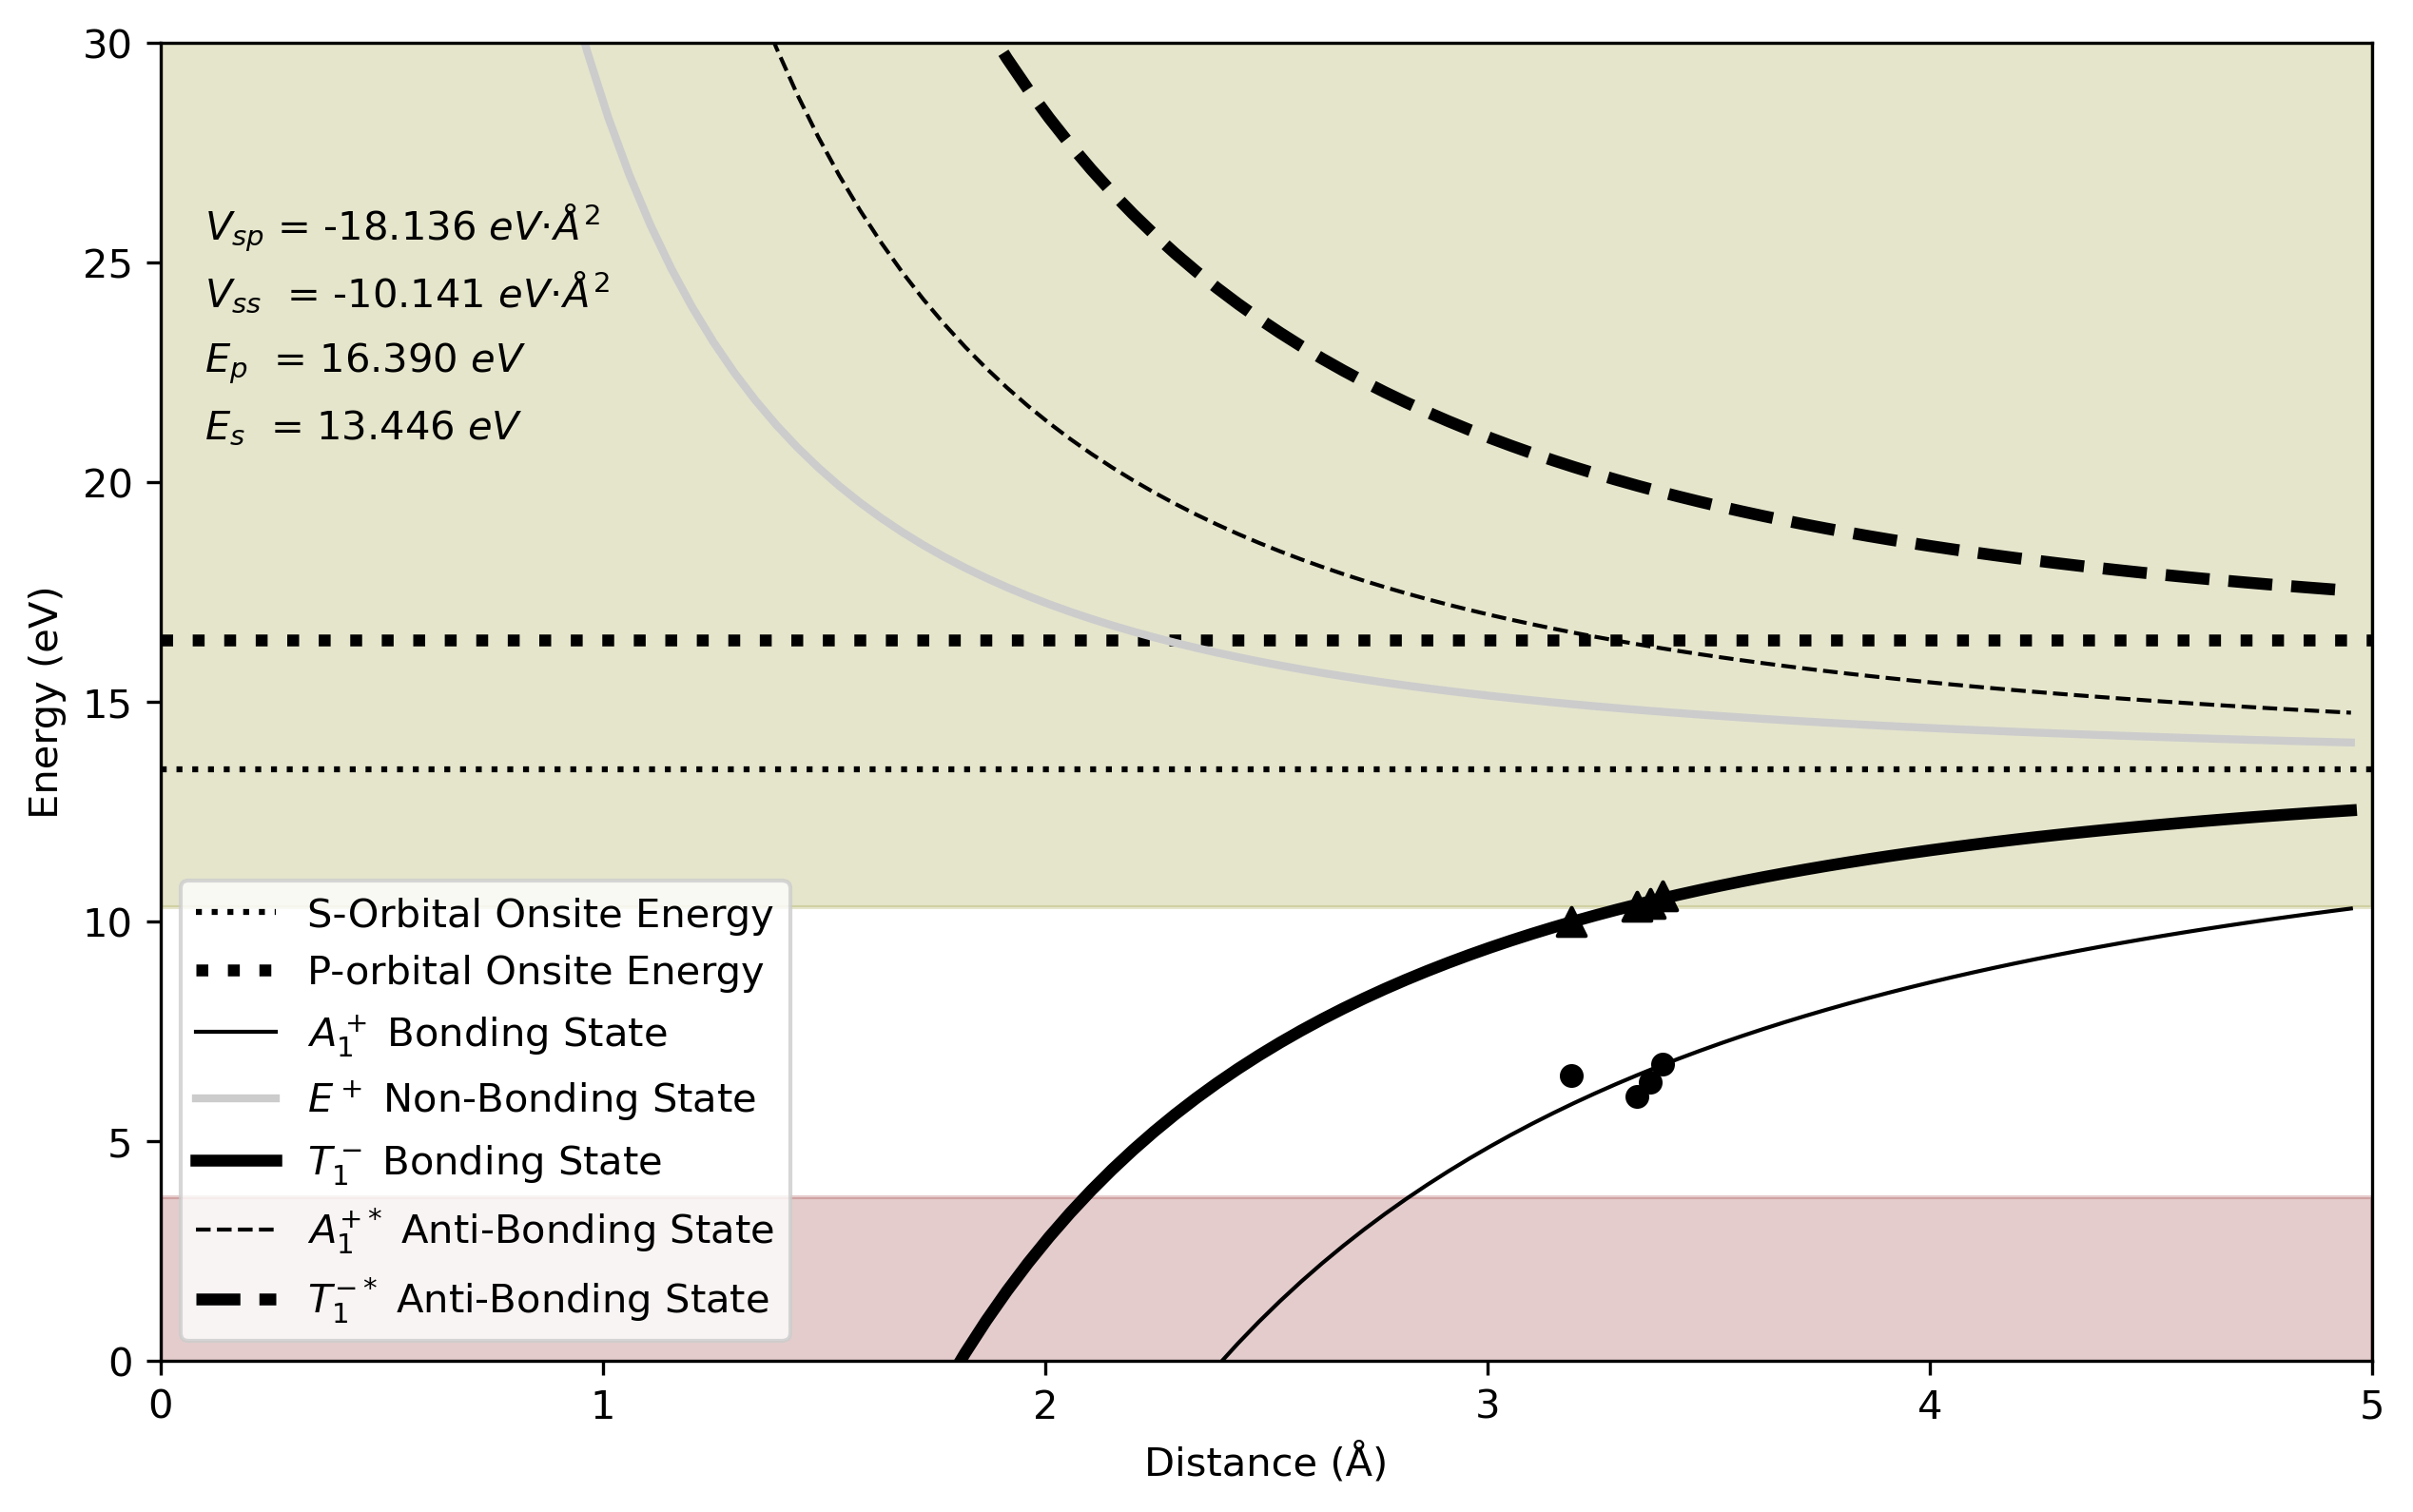

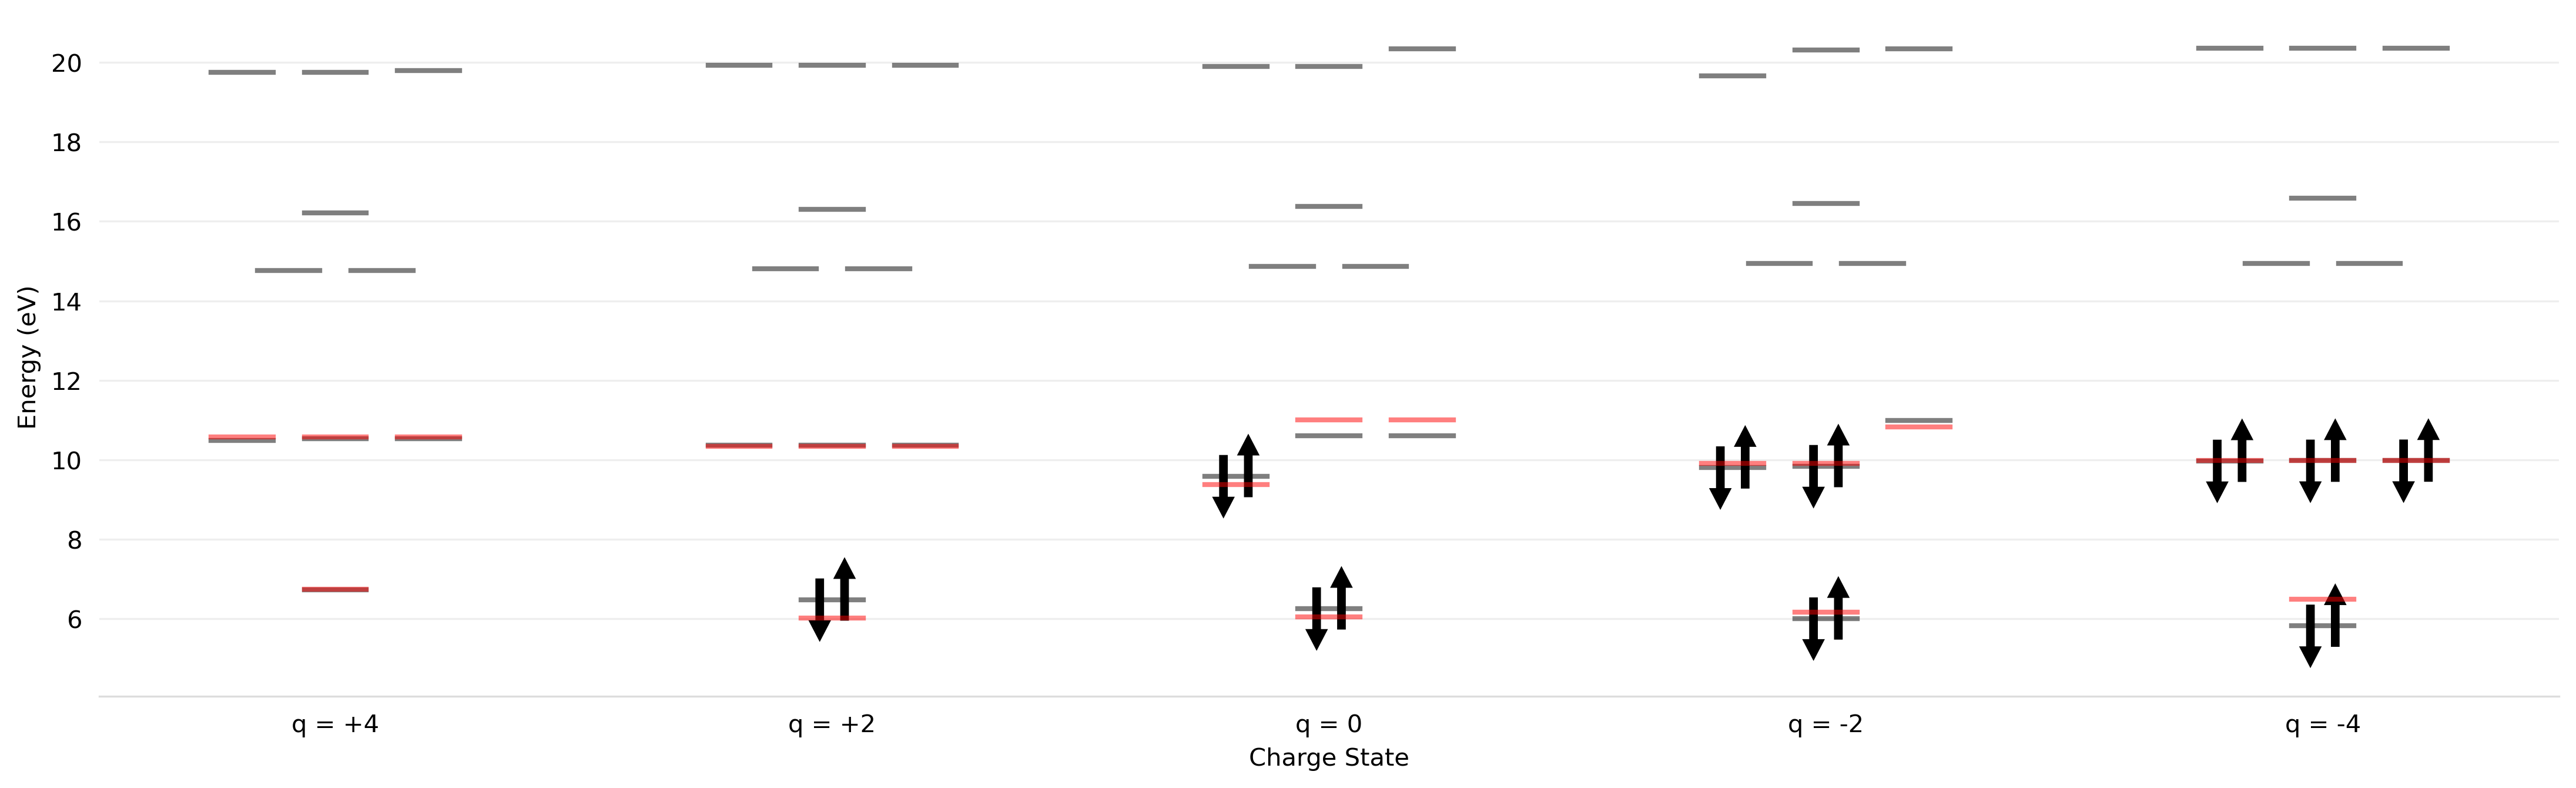

In [172]:
Vm = 0
Es = 13.446
########################################################################
#Tight Binding Hamiltonian Fitting
########################################################################

def residual(params):
    res_list = []
    for i, dist_mat in enumerate(dist_mat_list):
        
        #Magnesium Antisite data with Oh or D3d Point Groups
        if i in [0, 1, 2, 8]:
            a1plus = a1plus_bonding_energy(avg_edge_lengths[i], Es, params[0], 0)
            t1minus = t1minus_bonding_energy(avg_edge_lengths[i],  Es, params[0], params[1], params[2])
            e_list = np.array([a1plus,t1minus])
            energy = np.array([energy_list[i][0], np.mean(energy_list[i][1:])])
            res_list.append(energy-e_list)
    
    res_list = np.concatenate(res_list)
            
    #Oxygen Vacancy Data
    for i, d in enumerate(oxygen_vacancy_dist):  
        dist_mat = symmetric_distance_matrix(d)
        sp_proj = symmetric_sp_angle()
        H = Mg_Antisite_Hamiltonian(dist_mat, sp_proj, Es, *params, 0)
        O_vac_energy = energy_expectation_value(H, [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])
        np.insert(res_list, -1, O_vac_energy-oxygen_vacancy_energies[i])
    
    return res_list
        
r = np.random.random(3)
p0 = np.array([-13, 20, -30], dtype=np.float64)
results = least_squares(residual, r+p0)#, bounds=([-50, 0, -50], [0, 50, 0]))
Vss, Ep, Vsp = results['x']


##############################################################################################################################################
#Plots
##############################################################################################################################################
dlist = np.linspace(0.3, 5, 100)
energy_dict_list = [Mg_Antisite_Energies(symmetric_distance_matrix(d), symmetric_sp_angle(), Es, Vss, Ep, Vsp, Vm) for d in dlist]
clear_output(wait=True)
a1plus_bonding_energies = np.array([e_dict['a1plus']['Energies'][0] for e_dict in energy_dict_list])
a1plus_antibonding_energies = np.array([e_dict['a1plus*']['Energies'][0] for e_dict in energy_dict_list])
eplus_energies = np.array([np.mean(e_dict['eplus']['Energies']) for e_dict in energy_dict_list])
t1minus_bonding_energies = np.array([np.mean(e_dict['t1minus']['Energies']) for e_dict in energy_dict_list])
t1minus_antibonding_energies = np.array([np.mean(e_dict['t1minus*']['Energies']) for e_dict in energy_dict_list])

plt.figure(figsize=(10, 6), dpi=300)

breathing_mode_distance = avg_edge_lengths[[0,1, 2, 8]]


### Nonbonding States ###
plt.plot([0, max(dlist)], [Es, Es], label="S-Orbital Onsite Energy", c='k', linestyle='dotted')
plt.plot([0, max(dlist)], [Ep, Ep], label="P-orbital Onsite Energy", c='k', linestyle='dotted', linewidth=3)

### Bonding States ###
noi = non_outlier_indices(a1plus_bonding_energies)
plt.plot(dlist[noi], a1plus_bonding_energies[noi], label=r"$A_{1}^+$ Bonding State", c='k', linewidth=1)
noi = non_outlier_indices(eplus_energies)
plt.plot(dlist[noi], eplus_energies[noi], label=r"$E^+$ Non-Bonding State", c=(0.8, 0.8, 0.8), linewidth=2)
noi = non_outlier_indices(t1minus_bonding_energies)
plt.plot(dlist[noi], t1minus_bonding_energies[noi], label=r"$T_{1}^-$ Bonding State", c='k', linewidth=3)

### Anti-Bonding States ###
noi = non_outlier_indices(a1plus_antibonding_energies)
plt.plot(dlist[noi], a1plus_antibonding_energies[noi], label=r"$A_{1}^{+*}$ Anti-Bonding State", c='k', linewidth=1, linestyle='dashed')
noi = non_outlier_indices(t1minus_antibonding_energies)
plt.plot(dlist[noi], t1minus_antibonding_energies[noi], label=r"$T_{1}^{-*}$ Anti-Bonding State", c='k', linewidth=3, linestyle='dashed')

###  Bands ###
plt.fill_between([0, 5], -5, E_VBM, color=(0.5, 0, 0, 0.2))
plt.fill_between([0, 5], E_CBM, 30, color=(0.5, 0.5, 0, 0.2))

### DFT Data
plt.scatter(breathing_mode_distance, breathing_mode_a1plus, c='k', s=25)
plt.scatter(breathing_mode_distance, breathing_mode_t1minus, c='k', s=50, marker="^")

### Fitting Parameters
plt.text(0.1, 21, r"$E_s$  = {E:.3f} $eV$".format(E = Es))
plt.text(0.1, 22.5, r"$E_p$  = {E:.3f} $eV$".format(E = Ep))
plt.text(0.1, 24, r"$V_{ss}$" + r"  = {v:.3f} $eV · Å^2$".format(v = Vss))
plt.text(0.1, 25.5, r"$V_{sp}$" + r" = {v:.3f} $eV · Å^2$ ".format(v = Vsp))

plt.legend() 
plt.xlabel("Distance (Å)")
plt.ylabel("Energy (eV)")
plt.xlim(0, 5)
plt.ylim(0, 30)
plt.savefig("Mg_Antisite_energy.pdf", bbox_inches="tight")
plt.show()
plt.close()

###########################################################################################################################
# MO Diagrams
###########################################################################################################################
group_spacing = 4
n = 9
xpos = np.arange(n)*group_spacing
even_label_list = []
even_xpos = []
for i in range(9):
    if i % 2 == 0:
        even_label_list.append(label_list[i])
        even_xpos.append(xpos[i])

fig, ax = plt.subplots(figsize=(int(2*n),5), dpi=300)

for i, dist_mat in enumerate(dist_mat_list):
    if i in [0, 2, 4, 6, 8]:
        if i == 0:
            e_dict = Mg_Antisite_Energies(dist_mat, sp_proj_list[i], Es, Vss, Ep, Vsp, Vm)
            singlet(ax, xpos[i], e_dict["a1plus"]["Energies"][0])
            singlet(ax, xpos[i], e_dict["a1plus*"]["Energies"][0])
            doublet(ax, xpos[i], e_dict["eplus"]["Energies"])
            triplet(ax, xpos[i], e_dict["t1minus"]["Energies"])
            triplet(ax, xpos[i], e_dict["t1minus*"]["Energies"])
            singlet(ax, xpos[i], energy_list[i][0], color='r')
            triplet(ax, xpos[i], energy_list[i][1:], color='r')
        if i == 2:
            e_dict = Mg_Antisite_Energies(dist_mat, sp_proj_list[i], Es, Vss, Ep, Vsp, Vm)
            singlet(ax, xpos[i], e_dict["a1plus"]["Energies"][0], filled=True)
            singlet(ax, xpos[i], e_dict["a1plus*"]["Energies"][0])
            doublet(ax, xpos[i], e_dict["eplus"]["Energies"])
            triplet(ax, xpos[i], e_dict["t1minus"]["Energies"])
            triplet(ax, xpos[i], e_dict["t1minus*"]["Energies"])
            singlet(ax, xpos[i], energy_list[i][0], color='r')
            triplet(ax, xpos[i], energy_list[i][1:], color='r')
        if i == 4:
            e_dict = Mg_Antisite_Energies(dist_mat, sp_proj_list[i], Es, Vss, Ep, Vsp, Vm)
            singlet(ax, xpos[i], e_dict["a1plus"]["Energies"][0], filled=True)
            singlet(ax, xpos[i], e_dict["a1plus*"]["Energies"][0])
            doublet(ax, xpos[i], e_dict["eplus"]["Energies"])
            triplet(ax, xpos[i], e_dict["t1minus"]["Energies"], filling=[True, False, False])
            triplet(ax, xpos[i], e_dict["t1minus*"]["Energies"])
            singlet(ax, xpos[i], energy_list[i][0], color='r')
            triplet(ax, xpos[i], energy_list[i][1:], color='r')
        if i == 6:
            e_dict = Mg_Antisite_Energies(dist_mat, sp_proj_list[i], Es, Vss, Ep, Vsp, Vm)
            singlet(ax, xpos[i], e_dict["a1plus"]["Energies"][0], filled=True)
            singlet(ax, xpos[i], e_dict["a1plus*"]["Energies"][0])
            doublet(ax, xpos[i], e_dict["eplus"]["Energies"])
            triplet(ax, xpos[i], e_dict["t1minus"]["Energies"], filling=[True, True, False])
            triplet(ax, xpos[i], e_dict["t1minus*"]["Energies"])
            singlet(ax, xpos[i], energy_list[i][0], color='r')
            triplet(ax, xpos[i], energy_list[i][1:], color='r')
        if i == 8:
            e_dict = Mg_Antisite_Energies(dist_mat, sp_proj_list[i], Es, Vss, Ep, Vsp, Vm)
            singlet(ax, xpos[i], e_dict["a1plus"]["Energies"][0], filled=True)
            singlet(ax, xpos[i], e_dict["a1plus*"]["Energies"][0])
            doublet(ax, xpos[i], e_dict["eplus"]["Energies"])
            triplet(ax, xpos[i], e_dict["t1minus"]["Energies"], filling=[True, True, True])
            triplet(ax, xpos[i], e_dict["t1minus*"]["Energies"])
            singlet(ax, xpos[i], energy_list[i][0], color='r')
            triplet(ax, xpos[i], energy_list[i][1:], color='r')
        
        H = Mg_Antisite_Hamiltonian(dist_mat, sp_proj_list[i], Es, Vss, Ep, Vsp, Vm)
        
        #a1plus states
        psi = bonding_state(H, [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])
        e1 = energy_expectation_value(H, psi)
        #singlet(ax, xpos[i], e1, color='grey')
        psi = antibonding_state(H, [-1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])
        e1 = energy_expectation_value(H, psi)
        #singlet(ax, xpos[i], e1, color='grey')
        #eplus states
        e1 = energy_expectation_value(H, [0., 0., 0., 0., 1.,-1.,1.,-1., 0., 0.])
        e2 = energy_expectation_value(H, [0., 0., 0., 0., 1., 1.,1., 1.,-2.,-2.])
        #doublet(ax, xpos[i], [e1, e2], color='grey')
        #t1minus states
        t1minus_state_list = [
                        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
                        [0., 0., 0., 0., 1., 0.,-1., 0., 0., 0.],
                        [0., 0., 0., 0., 0., 1., 0.,-1., 0., 0.],
                        [0., 0., 0., 0., 0., 0., 0., 0., 1.,-1.]]
        energies, extremal_states = generic_bonding_system(H, t1minus_state_list)
        #bonding
        #triplet(ax, xpos[i], energies[:3], color='grey')
        #antibonding
        #triplet(ax, xpos[i], energies[3:], color='grey')

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xticks(even_xpos)
ax.set_xticklabels(even_label_list)
ax.set_xlabel("Charge State")
plt.ylabel("Energy (eV)")
plt.savefig("Mg_Antisite_MO.pdf", bbox_inches="tight")
plt.show()  
plt.close()

<h3>Oxygen Antisite</h3>

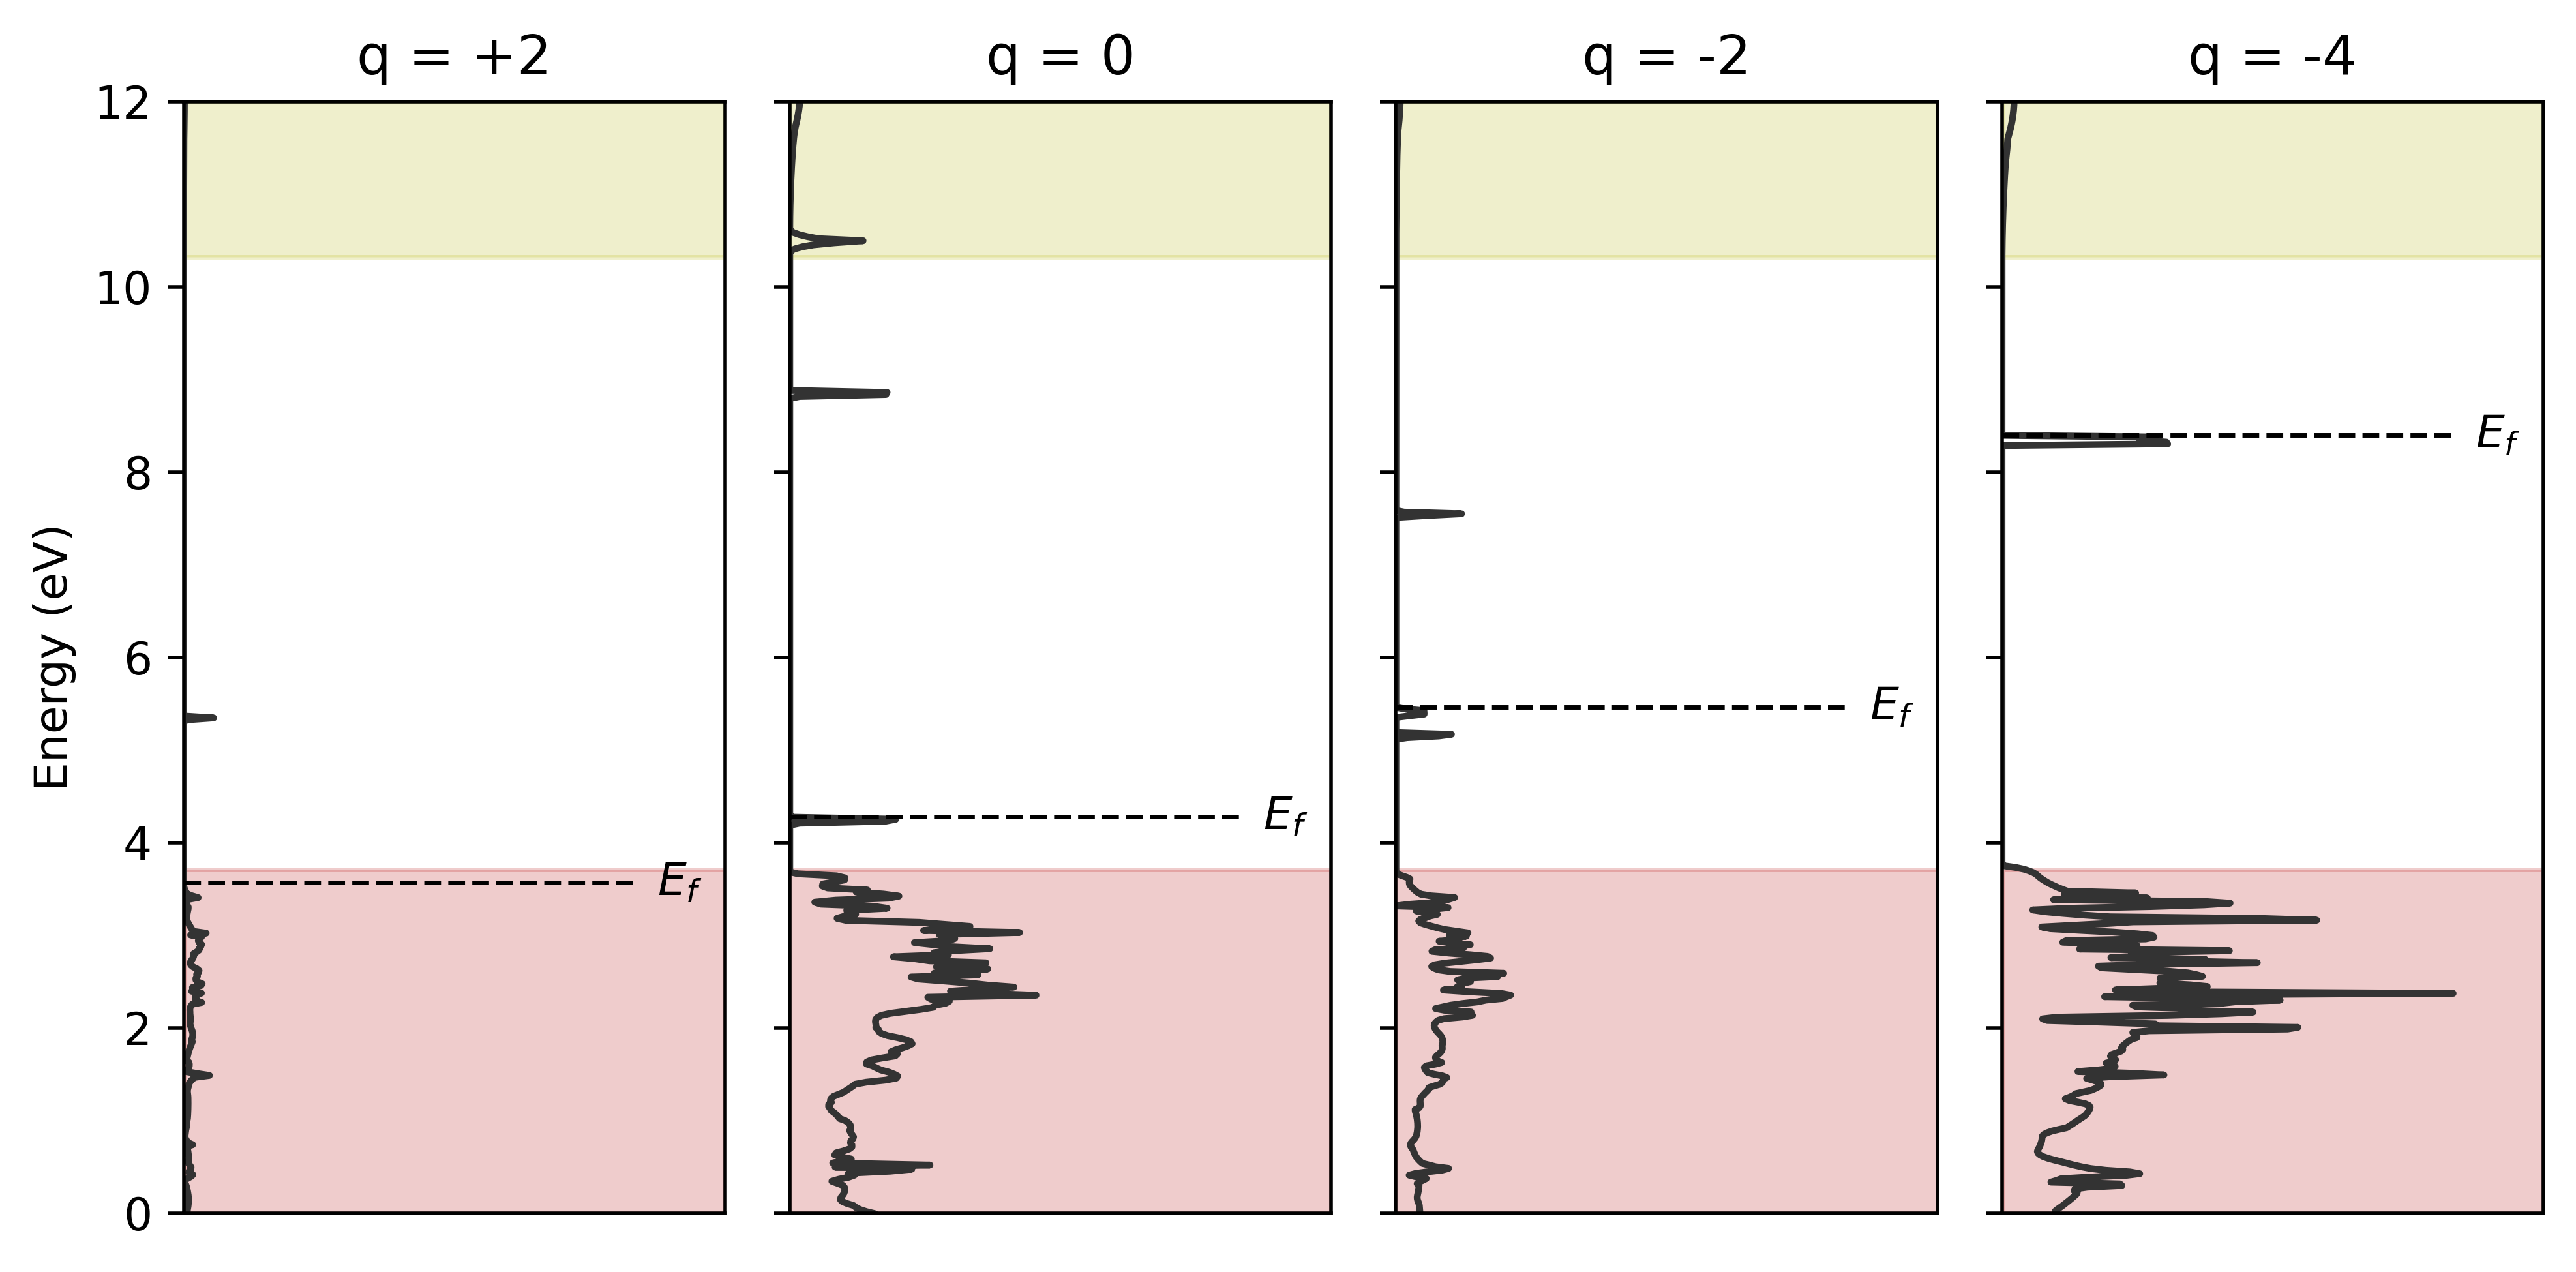

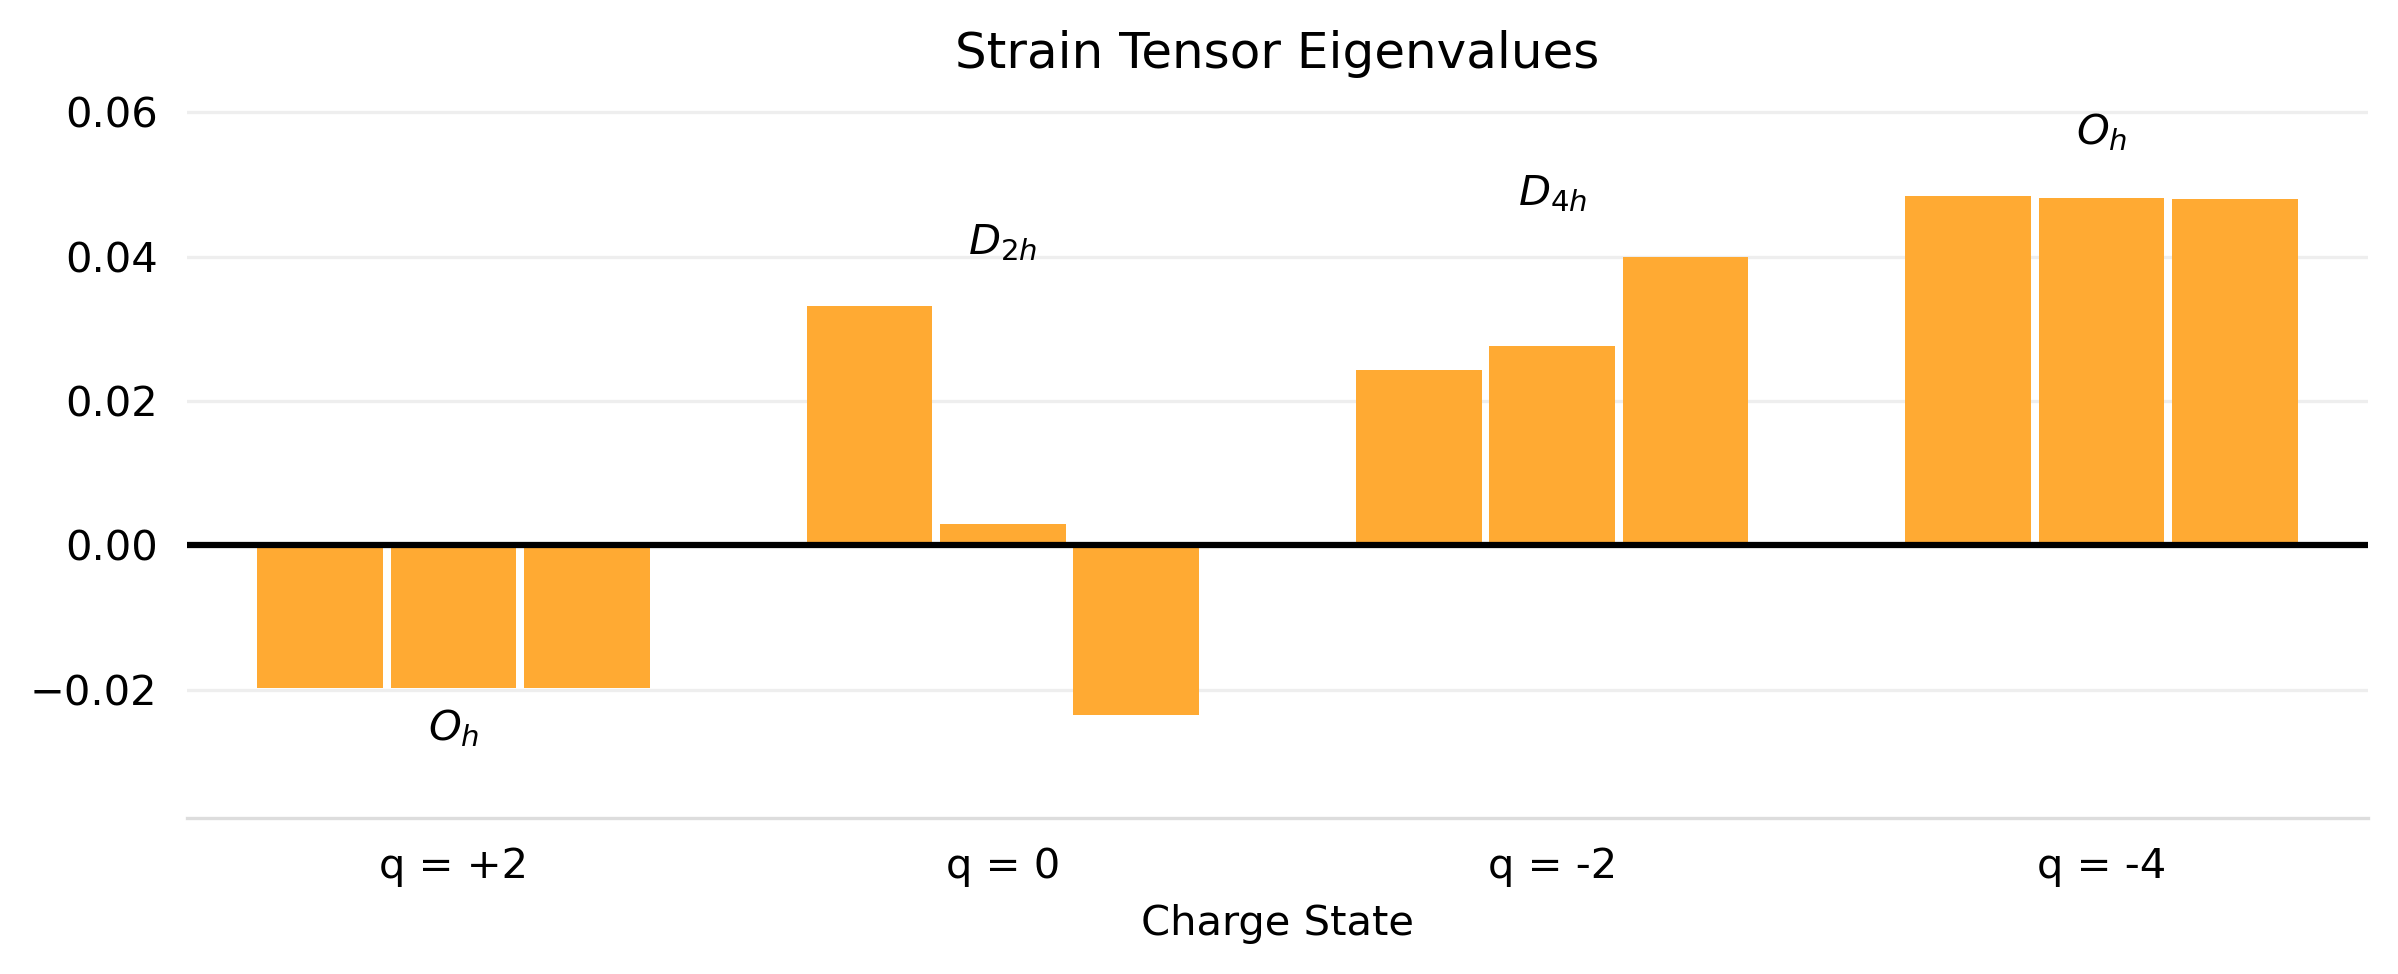

In [163]:
#Density of States Plots
base = "../DFT_Data/No_Sym/Oxygen_Antisite/DOS/"
address_list = ["q+2", "q0",  "q-2", "q-4"] 
savename = "O_Antisite_DOS.pdf"
label_list = ["q = +2", "q = 0", "q = -2", "q = -4"] 
fermi_level_data = pd.read_csv(base+"Fermi_Level.txt", delim_whitespace=True)
fermi_level_list = list(fermi_level_data["Fermi_Level"][[0, 2, 4, 6]])
doscar_plot(base, address_list, savename, label_list, fermi_level_list)

#Atomic Positions
reference = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Antisite/POS/reference", delim_whitespace=True)
qplus2_pos = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Antisite/POS/q+2", delim_whitespace=True)
q0_pos = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Antisite/POS/q0", delim_whitespace=True)
qminus2_pos = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Antisite/POS/q-2", delim_whitespace=True)
qminus4_pos = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Antisite/POS/q-4", delim_whitespace=True)

defect_pos = lattice_constant*np.array([0.5, 0.5, 0.5])
defect_index = np.argwhere((np.array(reference["X"])==0.5)*(np.array(reference["Y"])==0.5)*(np.array(reference["Z"])==0.5))[0][0]
pos_list = [qplus2_pos, q0_pos, qminus2_pos, qminus4_pos]
ref_pos = (lattice_constant*np.array(reference["X"]), 
           lattice_constant*np.array(reference["Y"]), 
           lattice_constant*np.array(reference["Z"]))

strain_eigenvalues = []
pg_list = []
for i, pos in enumerate(pos_list):
    
    
    atomic_pos = (lattice_constant*np.array(pos["X"]), 
                  lattice_constant*np.array(pos["Y"]), 
                  lattice_constant*np.array(pos["Z"]))
    
    #print(label_list[0])
    #displacement_plot(atomic_pos, ref_pos, 31, 33)
    
    strain_tensor = generate_strain_tensor(defect_pos, atomic_pos, ref_pos)
    eigvals = np.linalg.eigvals(strain_tensor)
    strain_eigenvalues += list(eigvals)
    
    nn_indices = nearest_neighbor_indices(defect_pos, ref_pos)
    x, y, z = atomic_pos[0][nn_indices], atomic_pos[1][nn_indices], atomic_pos[2][nn_indices]    
    real_defect_pos = (atomic_pos[0][defect_index], atomic_pos[1][defect_index], atomic_pos[2][defect_index])
    
    pg_list.append(point_group((x, y, z), real_defect_pos))
    
strain_tensor_bar(strain_eigenvalues, label_list, pg_list, "O_antisite")

<h3>Oxygen Interstitial</h3>

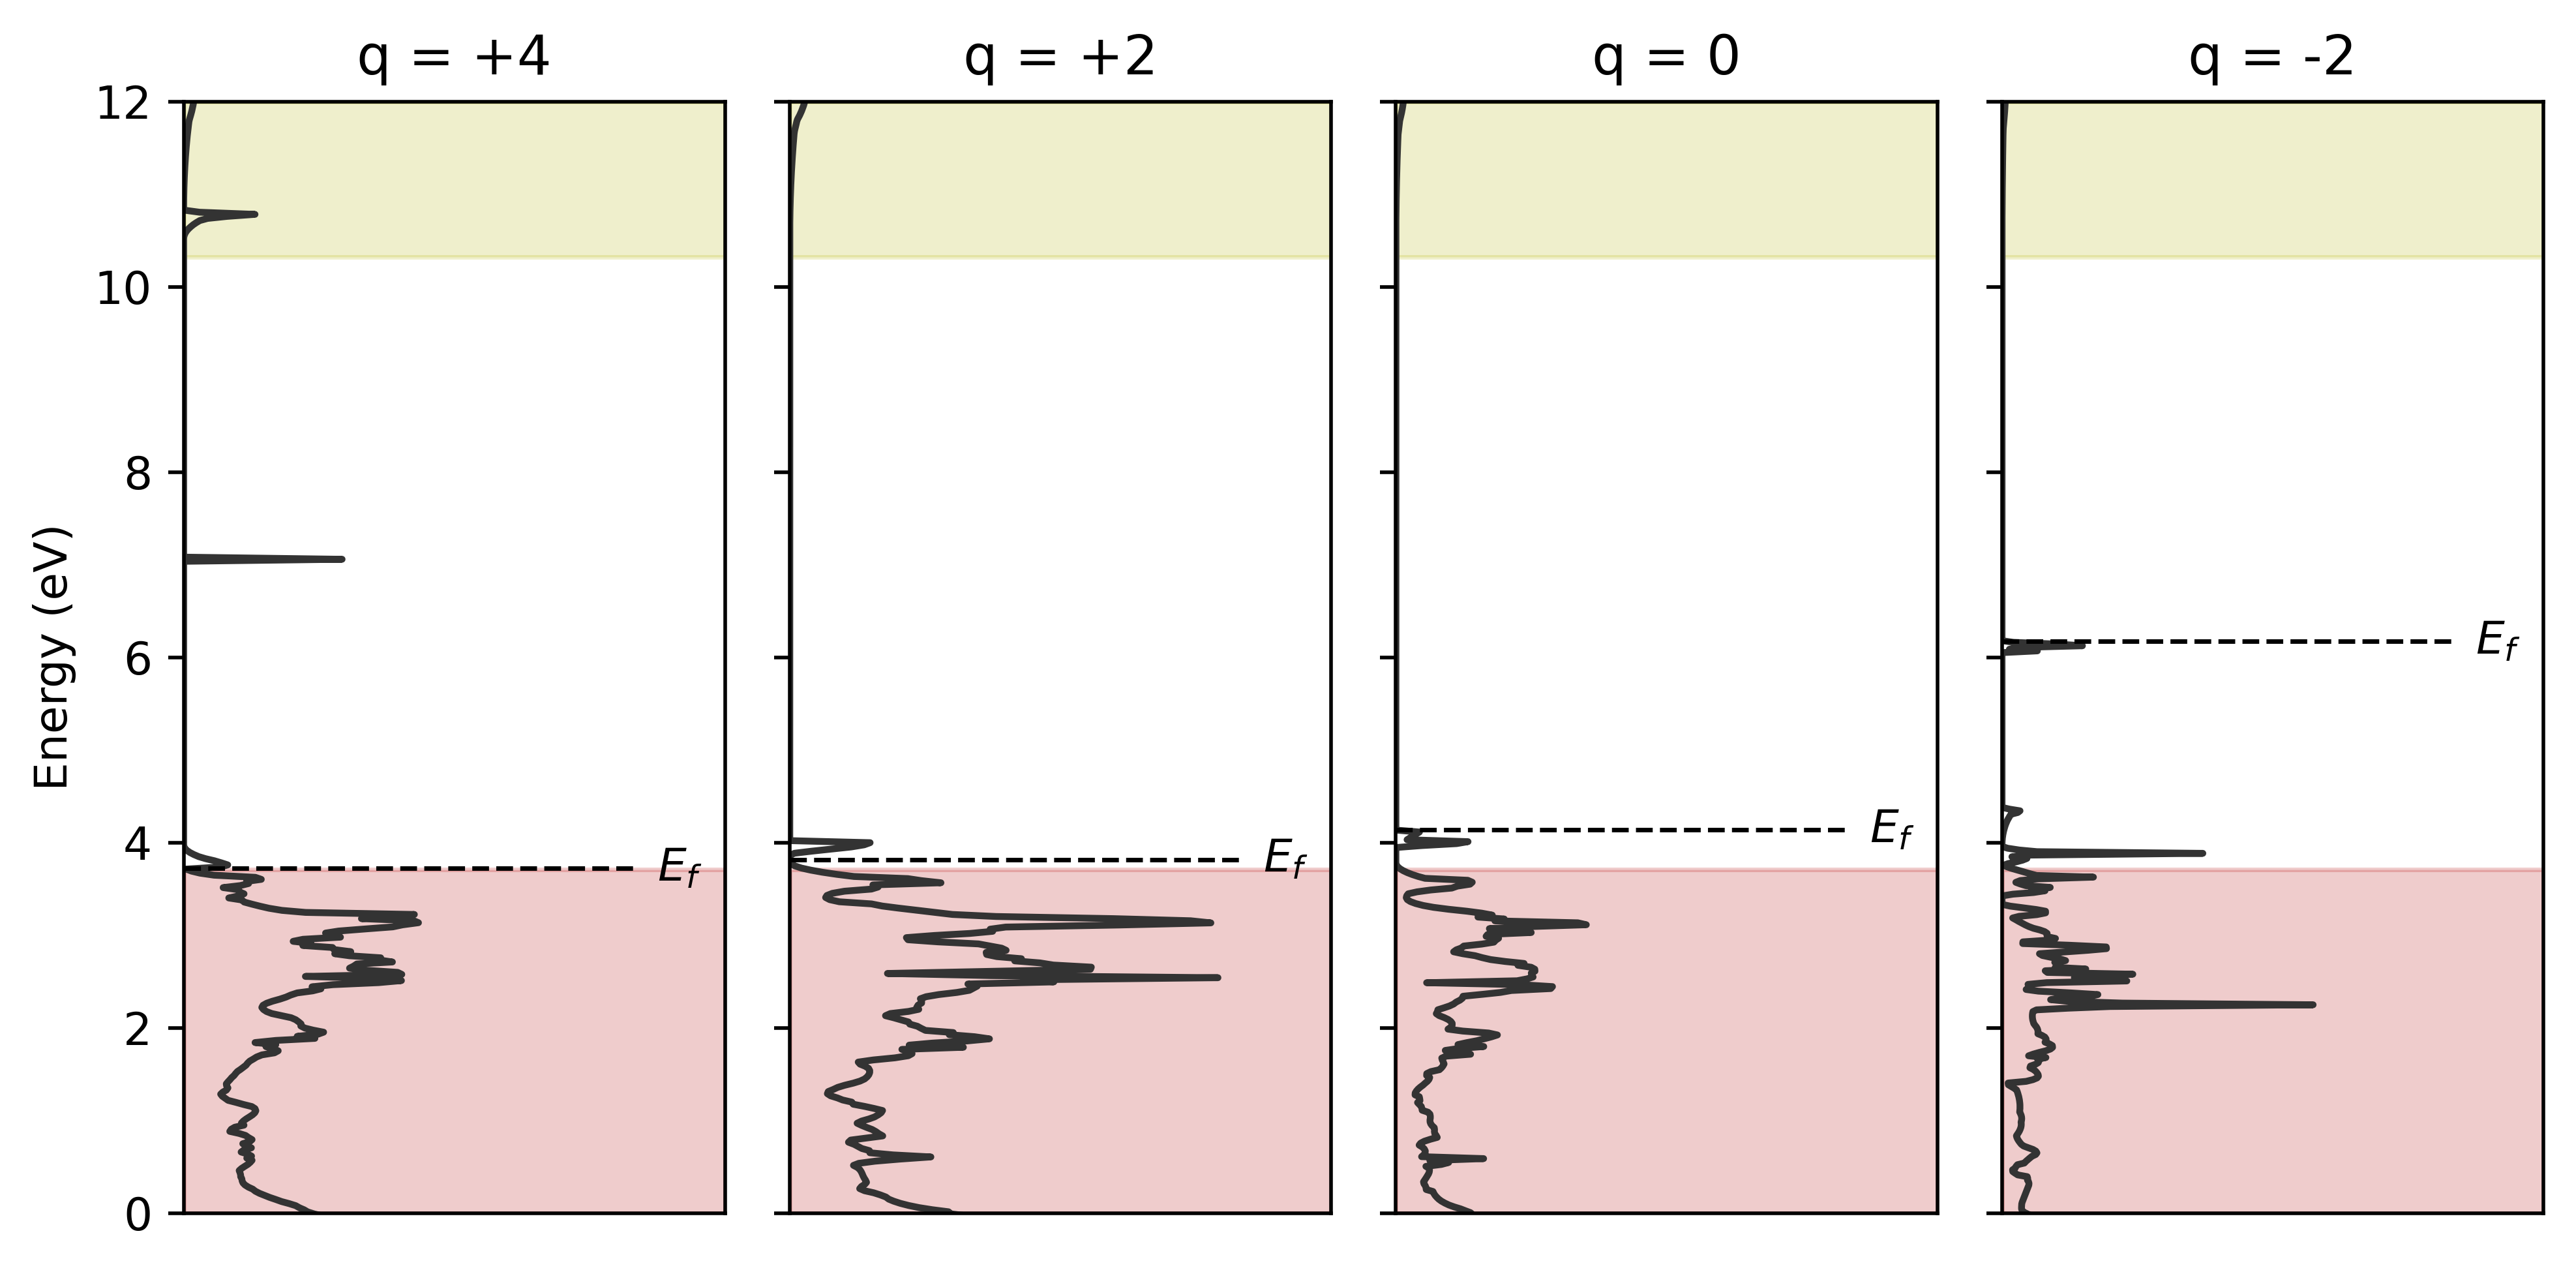

q = +4


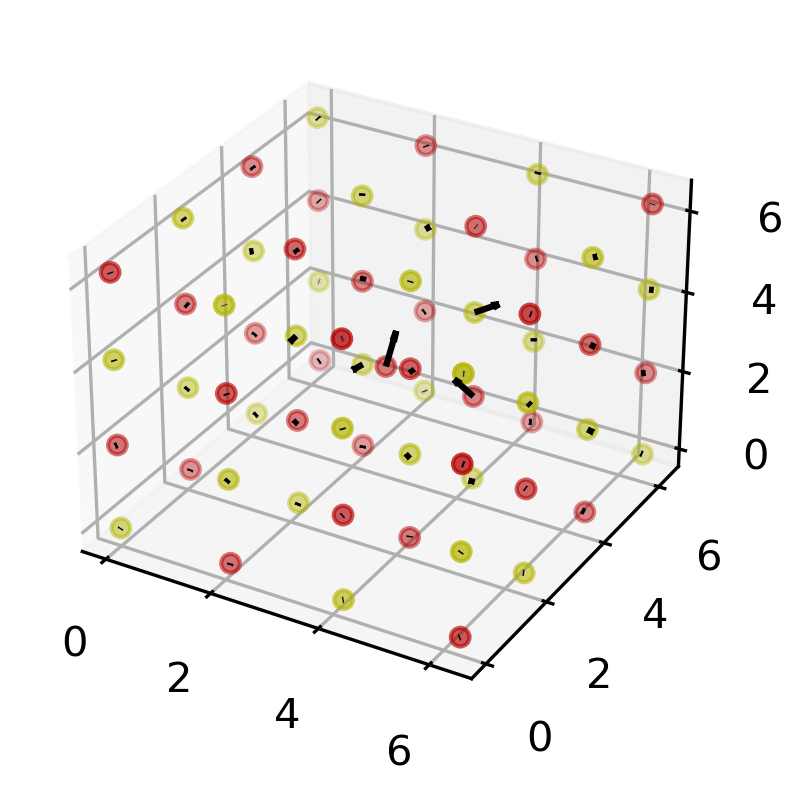

q = +2


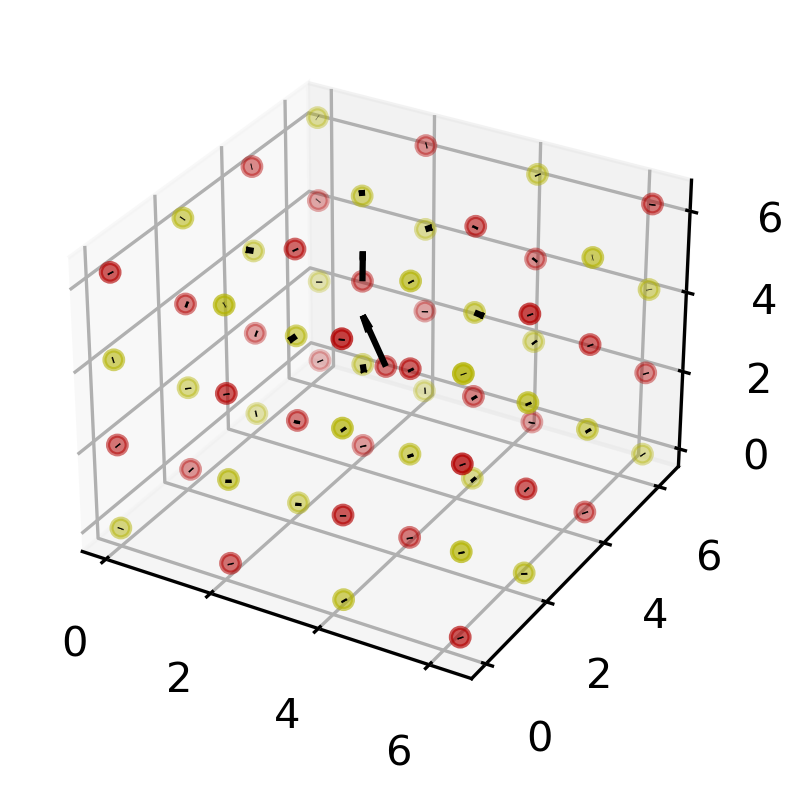

q = 0


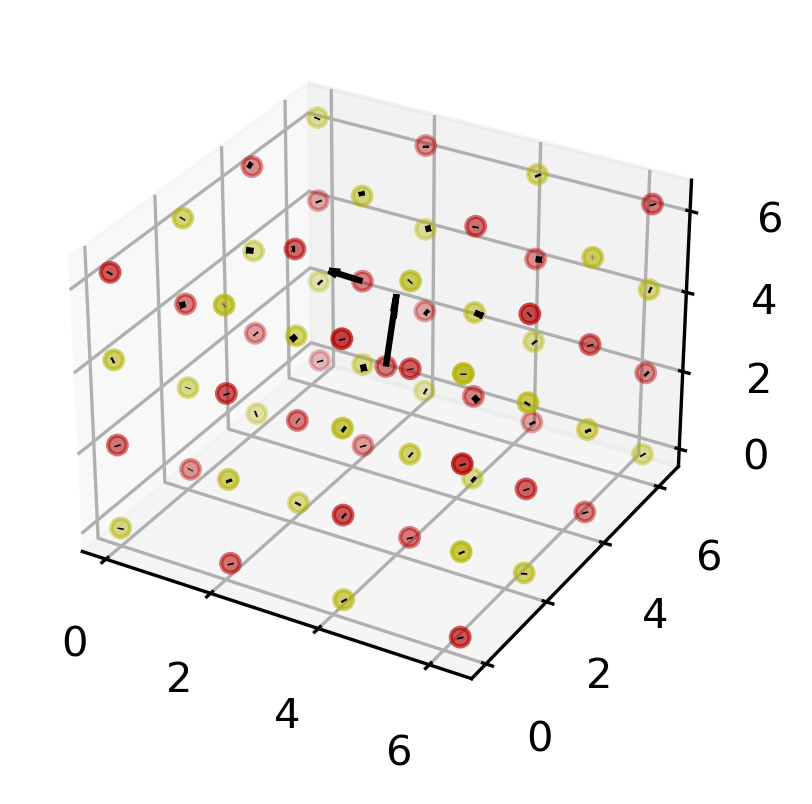

q = -2


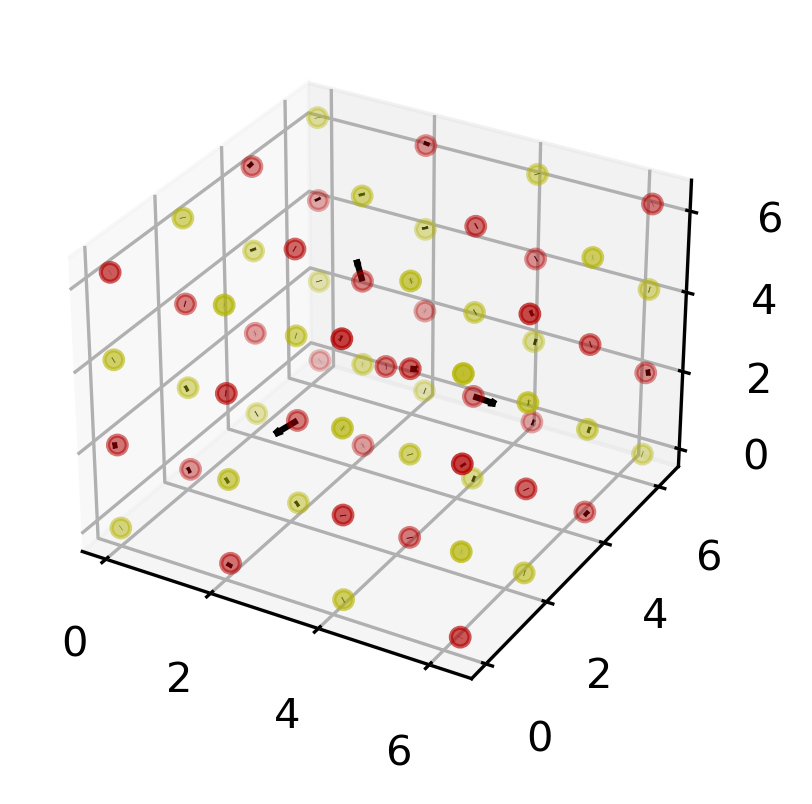

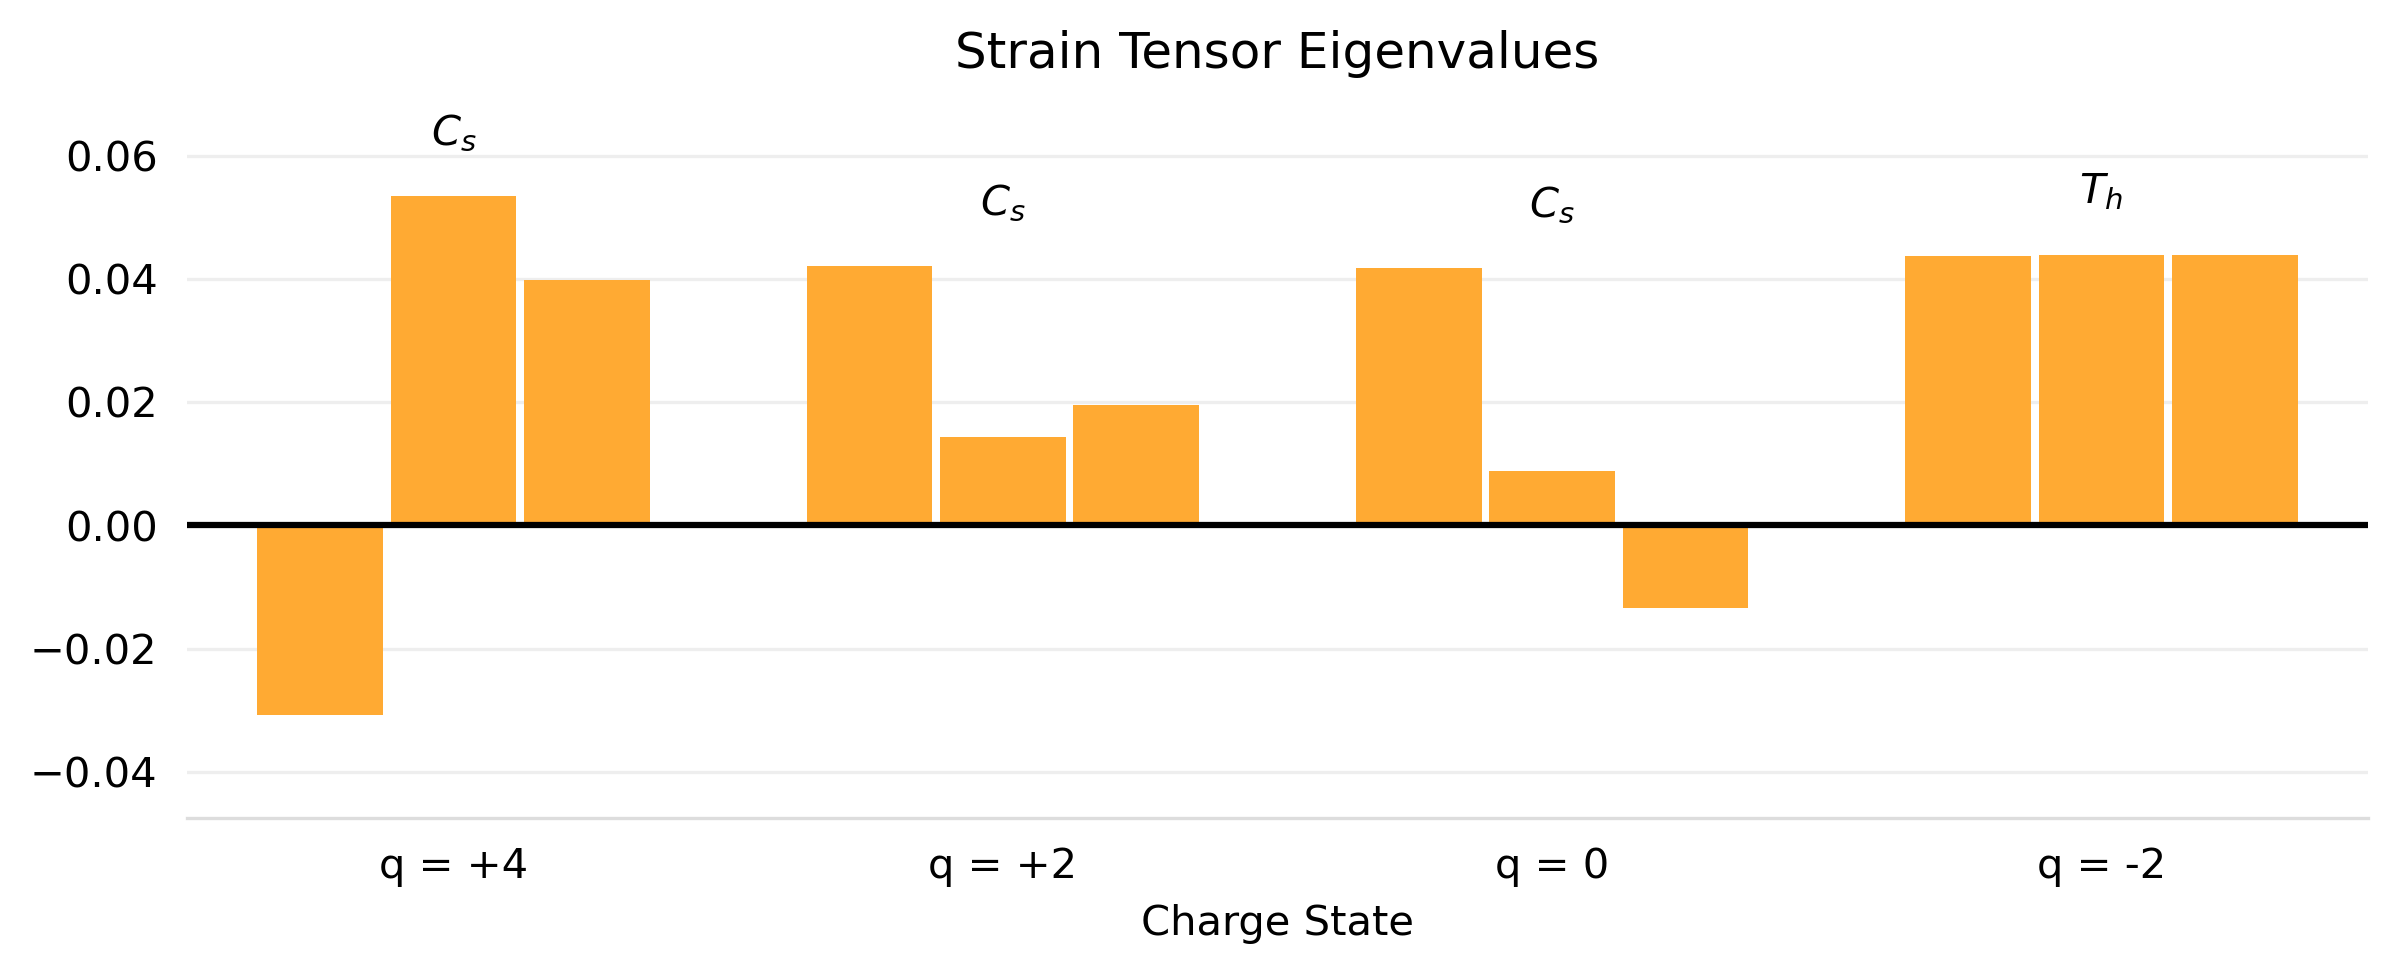

In [164]:
#Density of States Plots
base = "../DFT_Data/No_Sym/Oxygen_Interstitial/DOS/"
address_list = ["q+4", "q+2",   "q0",  "q-2"] 
savename = "O_Interstitial_DOS.pdf"
label_list = ["q = +4", "q = +2",  "q = 0", "q = -2"]
fermi_level_data = pd.read_csv(base+"Fermi_Level.txt", delim_whitespace=True)
fermi_level_list = list(fermi_level_data["Fermi_Level"][[0, 2, 4, 6]])
doscar_plot(base, address_list, savename, label_list, fermi_level_list)

#Atomic Positions
reference = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Interstitial/POS/reference", delim_whitespace=True)
qplus2_pos = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Interstitial/POS/q+2", delim_whitespace=True)
q0_pos = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Interstitial/POS/q0", delim_whitespace=True)
qminus2_pos = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Interstitial/POS/q-2", delim_whitespace=True)
qplus4_pos = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Interstitial/POS/q+4", delim_whitespace=True)

defect_pos = lattice_constant*np.array([0.375, 0.375, 0.375])
defect_index = np.argwhere((np.array(reference["X"])==0.375)*(np.array(reference["Y"])==0.375)*(np.array(reference["Z"])==0.375))[0][0]
pos_list = [qplus4_pos, qplus2_pos, q0_pos, qminus2_pos]
ref_pos = (lattice_constant*np.array(reference["X"]), 
           lattice_constant*np.array(reference["Y"]), 
           lattice_constant*np.array(reference["Z"]))

nn_indices = nearest_neighbor_indices(defect_pos, ref_pos)
strain_eigenvalues = []
pg_list = []
for i, pos in enumerate(pos_list):

    
    atomic_pos = (lattice_constant*np.array(pos["X"]), 
                  lattice_constant*np.array(pos["Y"]), 
                  lattice_constant*np.array(pos["Z"]))
    
    print(label_list[i])
    displacement_plot(atomic_pos, ref_pos, 32, 33, arrow_length=1)

    strain_tensor = generate_strain_tensor(defect_pos, atomic_pos, ref_pos)
    eigvals = np.linalg.eigvals(strain_tensor)
    strain_eigenvalues += list(eigvals)
    
    nx, ny, nz = atomic_pos[0][nn_indices], atomic_pos[1][nn_indices], atomic_pos[2][nn_indices]
    x, y, z = atomic_pos[0], atomic_pos[1], atomic_pos[2]
    real_defect_pos = (atomic_pos[0][defect_index], atomic_pos[1][defect_index], atomic_pos[2][defect_index])


    pg_list.append(point_group((nx, ny, nz), real_defect_pos))

strain_tensor_bar(strain_eigenvalues, label_list, pg_list, "O_intersitial")

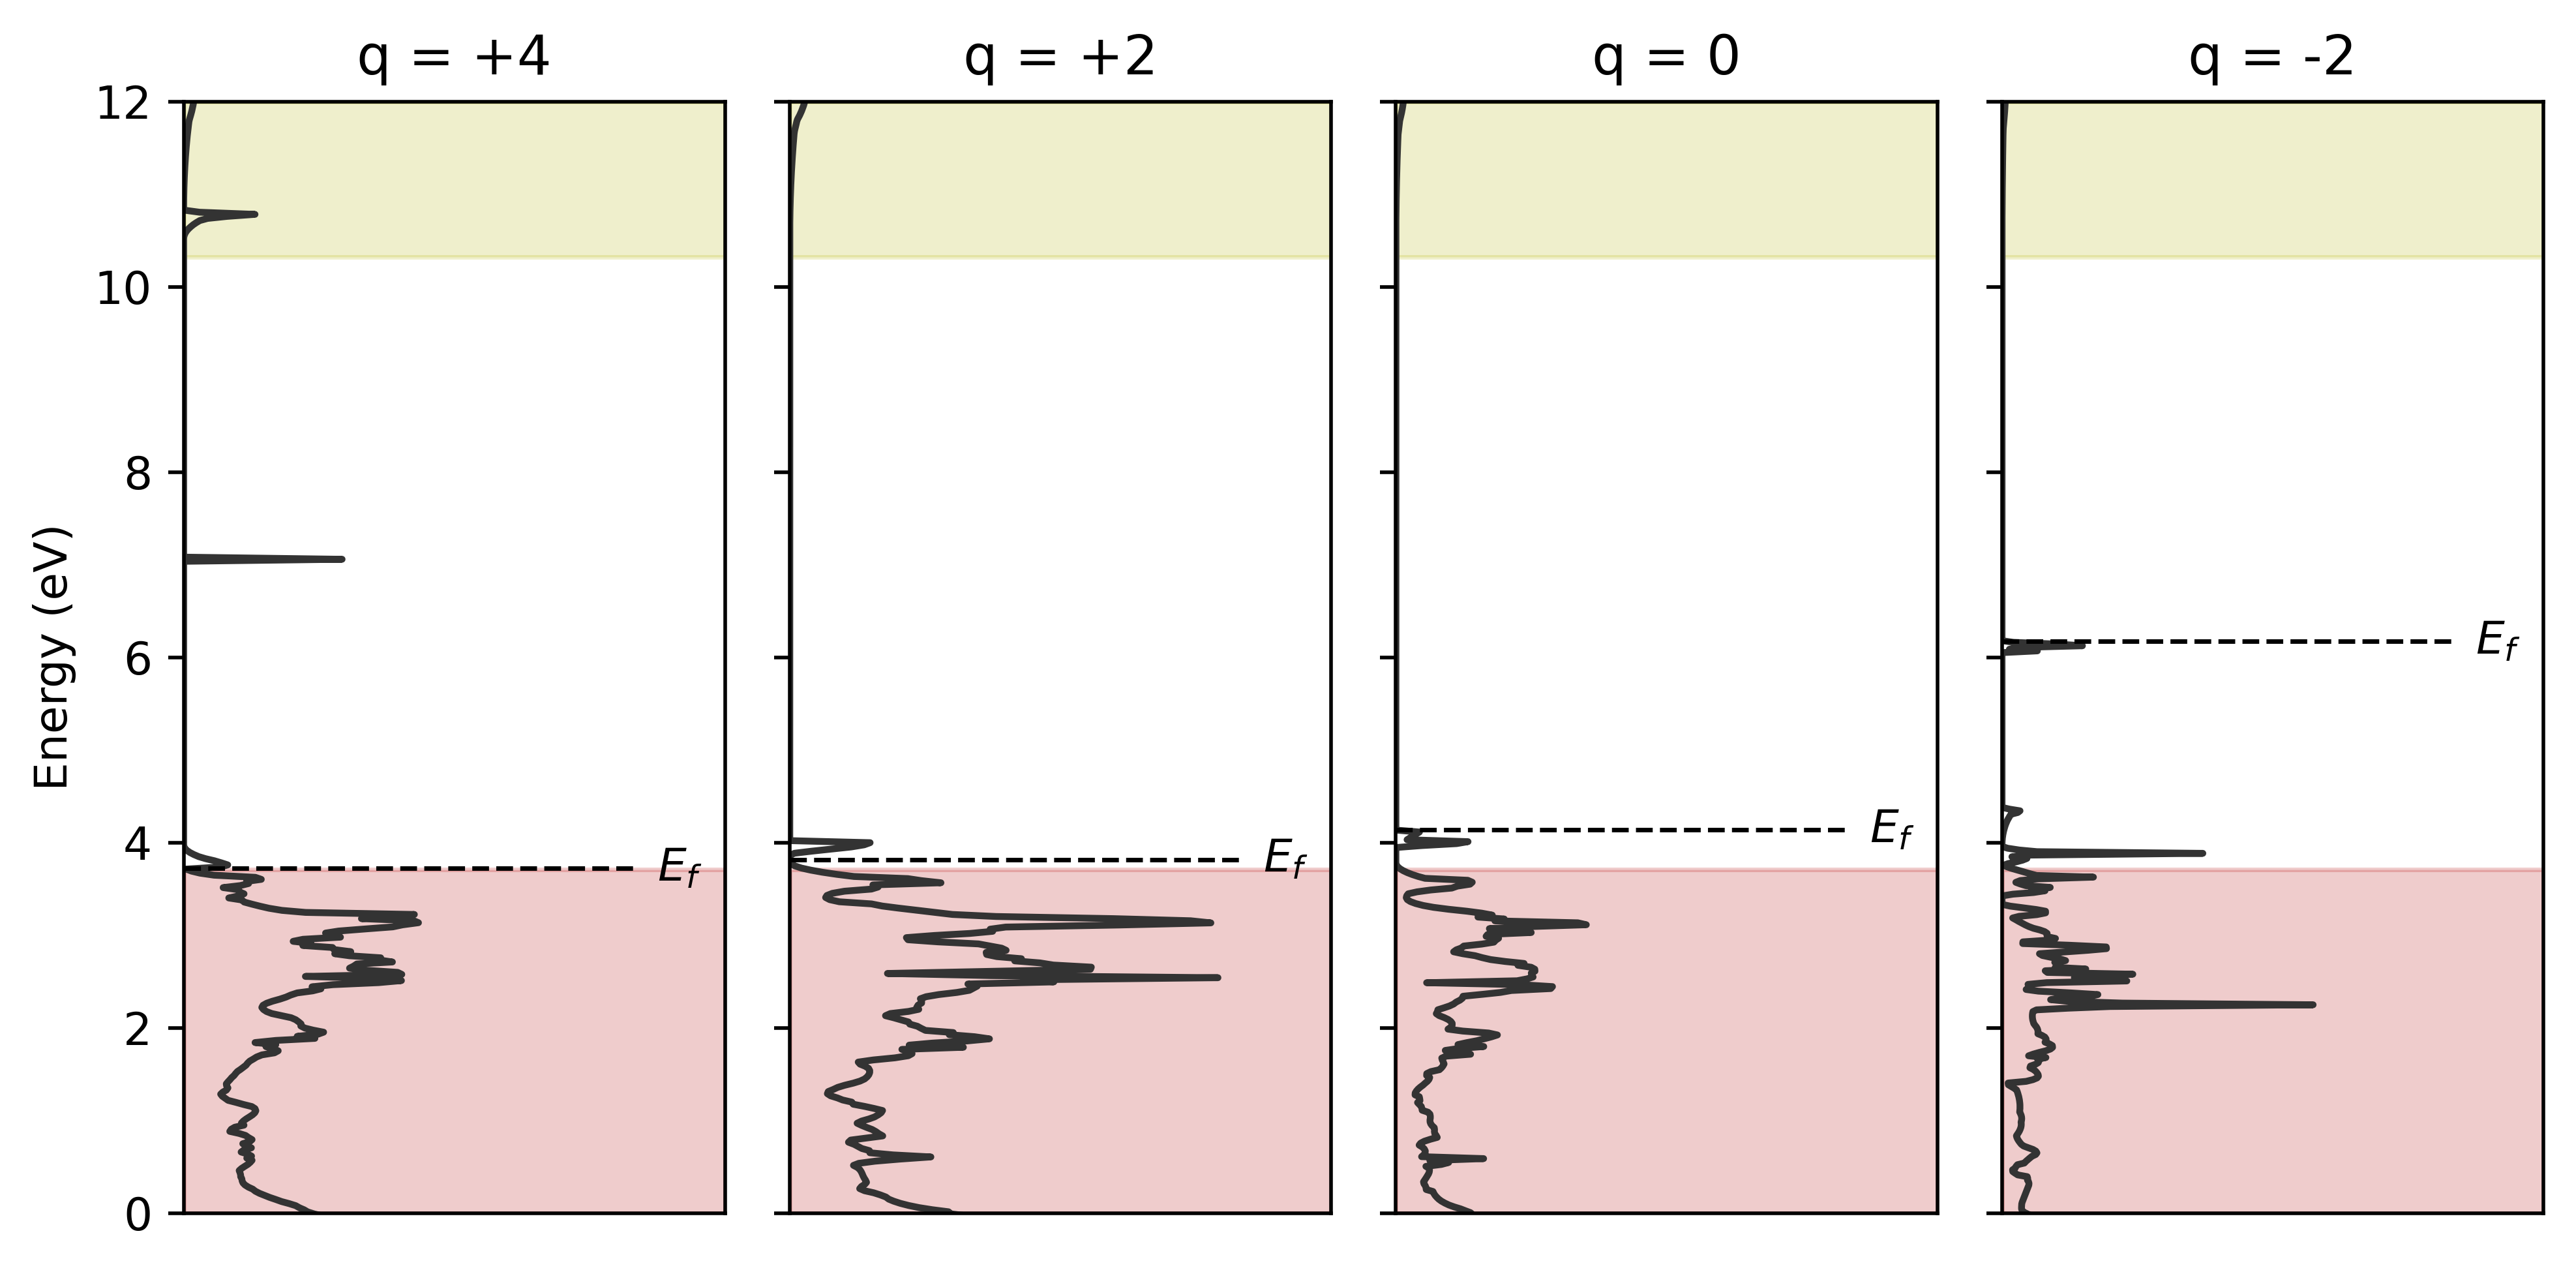

q = +2
O 0.6615268149839783
O 0.6615268149839784
Mg 2.2489066569881744
Mg 2.25668272350754
Mg 2.283123015766799
Mg 2.2846925604073878
Mg 2.295584637450653
Mg 2.2985433263207375
O 2.926754296596141
O 2.929015745078954
O 2.935629659489562
O 2.9383934583430755
O 2.944915338240234
O 2.945259262589998
O 2.97749978534498
O 2.9825095745315333
O 2.9873292839231325
O 3.001167097295818
O 3.0041521368476585
O 3.012861475192576
Mg 3.6252419998362786
Mg 3.641849294445851
Mg 3.643571498454954
Mg 3.6448830058164816
Mg 3.648494022249327
Mg 3.6486762620349156
Mg 3.6502189983714155
Mg 3.6781581592434636
O 4.184546525804649
O 4.185919038837245
O 4.1891226144828035
Mg 4.679949011407096
Mg 4.680689977057269
Mg 4.683278537339403
Mg 4.683282001253408
Mg 4.685487293212152
Mg 4.685688157102609
Mg 4.687061419671588
Mg 4.687089671143778
Mg 4.687190708175511
Mg 4.688960789277689
Mg 4.697626608658685
Mg 4.698405480913592
O 5.115339127823045
O 5.116135220109995
O 5.119720114693771
O 5.121408082007477
O 5.1214908621

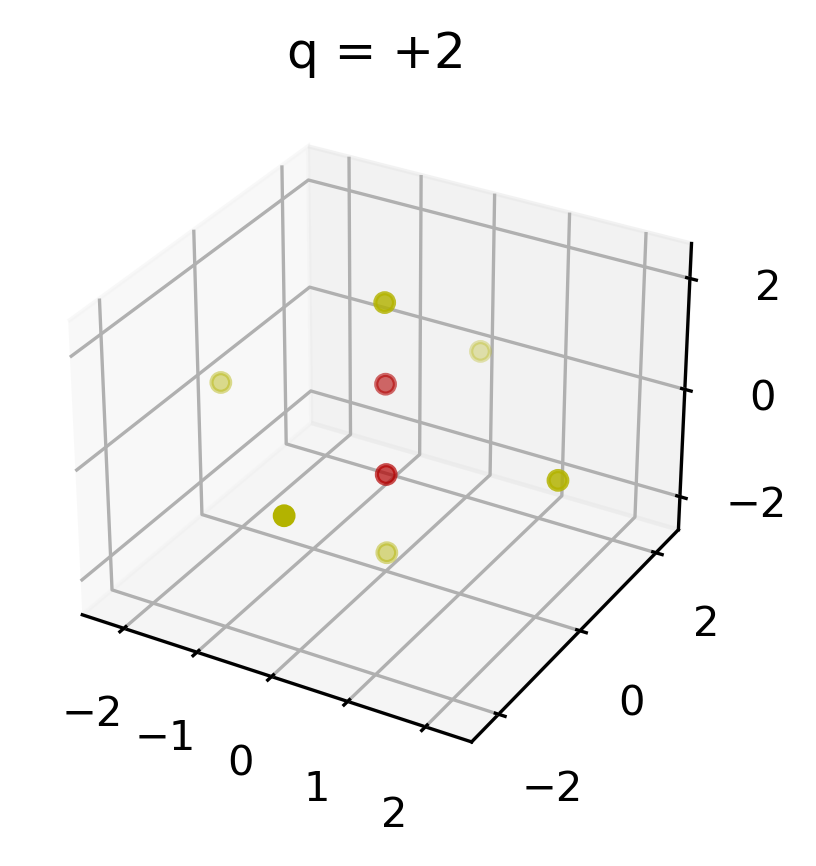

Point Group:  C*v


q = 0
O 0.699814352095224
O 0.699814352095224
Mg 2.2329267725122235
Mg 2.233139112656714
Mg 2.233782217217672
Mg 2.2339718519496907
Mg 2.2342158137555517
Mg 2.2343429657734606
O 2.9482007220057675
O 2.9484755025535767
O 2.9485665563958308
O 2.9491766335946275
O 2.9492697408908817
O 2.9500352493784243
O 3.0652003015845963
O 3.0653445245503104
O 3.065932471879737
O 3.066121854223032
O 3.066445302536152
O 3.0665964253910807
Mg 3.6260926857362876
Mg 3.626393788747178
Mg 3.6267623991663647
Mg 3.627888728838123
Mg 3.628062747526571
Mg 3.6285273492891634
Mg 3.649688080750739
Mg 3.6499986148452916
O 4.193243576571815
O 4.193269416490954
O 4.193361179346881
Mg 4.69364695933358
Mg 4.693679258335811
Mg 4.693778144745366
Mg 4.693890650543808
Mg 4.694189356726022
Mg 4.694561848237663
Mg 4.694688888794871
Mg 4.694746634056221
Mg 4.695280512710278
Mg 4.695442094128669
Mg 4.6954842592611294
Mg 4.695499895175966
O 5.124188202087656
O 5.124768519807447
O 5.12487085423605
O 5.12594590

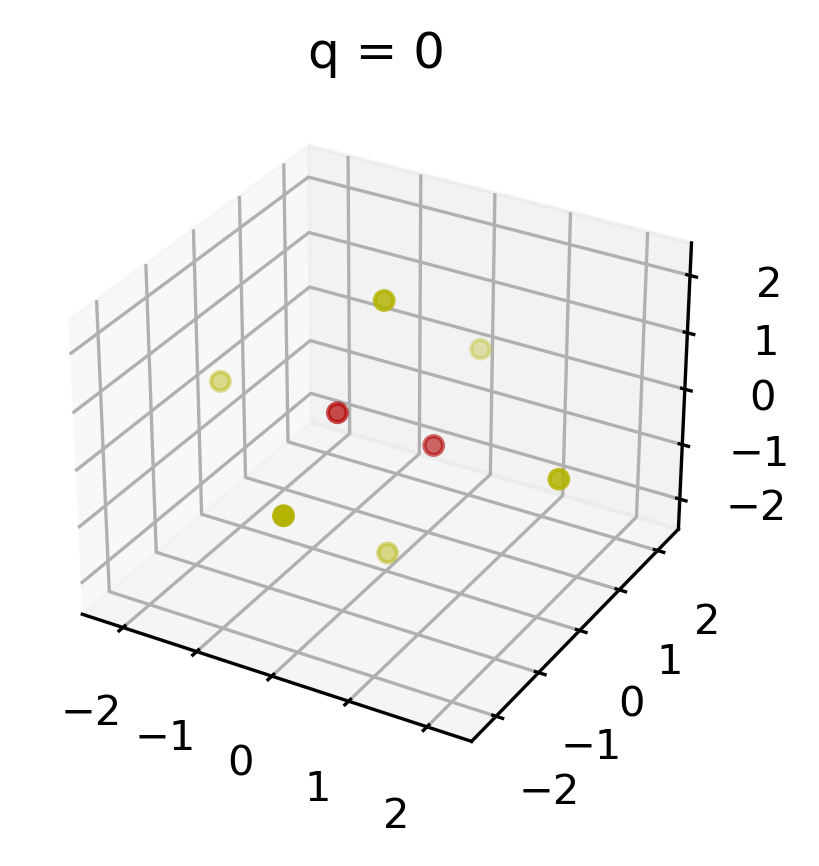

Point Group:  C*v




In [165]:
%matplotlib inline



#Density of States Plots
base = "../DFT_Data/No_Sym/Oxygen_Interstitial/DOS/"
address_list = ["q+4", "q+2",   "q0",  "q-2"] 
savename = "O_Interstitial_DOS.pdf"
label_list = ["q = +4", "q = +2",  "q = 0", "q = -2"]
fermi_level_data = pd.read_csv(base+"Fermi_Level.txt", delim_whitespace=True)
fermi_level_list = list(fermi_level_data["Fermi_Level"][[0, 2, 4, 6]])
doscar_plot(base, address_list, savename, label_list, fermi_level_list)

#Atomic Positions
reference = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Interstitial/POS/reference", delim_whitespace=True)
qplus2_pos = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Interstitial/POS/q+2", delim_whitespace=True)
q0_pos = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Interstitial/POS/q0", delim_whitespace=True)
qminus2_pos = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Interstitial/POS/q-2", delim_whitespace=True)
qplus4_pos = pd.read_csv("../DFT_Data/No_Sym/Oxygen_Interstitial/POS/q+4", delim_whitespace=True)

defect_pos = lattice_constant*np.array([0.375, 0.375, 0.375])
defect_index = np.argwhere((np.array(reference["X"])==0.375)*(np.array(reference["Y"])==0.375)*(np.array(reference["Z"])==0.375))[0][0]
pos_list = [qplus4_pos, qplus2_pos, q0_pos, qminus2_pos]
ref_pos = (lattice_constant*np.array(reference["X"]), 
           lattice_constant*np.array(reference["Y"]), 
           lattice_constant*np.array(reference["Z"]))

nn_indices = nearest_neighbor_indices(defect_pos, ref_pos)
strain_eigenvalues = []
pg_list = []
for i, pos in enumerate(pos_list):

    
    atomic_pos = (lattice_constant*np.array(pos["X"]), 
                  lattice_constant*np.array(pos["Y"]), 
                  lattice_constant*np.array(pos["Z"]))
    
    #print(label_list[i])
    #displacement_plot(atomic_pos, ref_pos, 32, 33, arrow_length=1)

    strain_tensor = generate_strain_tensor(defect_pos, atomic_pos, ref_pos)
    eigvals = np.linalg.eigvals(strain_tensor)
    strain_eigenvalues += list(eigvals)
    
    if i in [ 1, 2]:
        
        print(label_list[i])
        
        ### find peroxide bond center ###
        if i in [1, 2]:
            relaxed_defect_pos = atomic_pos[0][defect_index], atomic_pos[1][defect_index], atomic_pos[2][defect_index]
            dx, dy, dz = difference_from_point(relaxed_defect_pos, atomic_pos)
            dist_from_defect = np.sqrt(dx**2 + dy**2 + dz**2)
            sort_indices = np.argsort(dist_from_defect)
            O_atoms = (np.arange(dx.shape[0]) >= 32)[sort_indices]
            sort_distances = dist_from_defect[sort_indices][O_atoms]
            original_indices = np.arange(dx.shape[0])[sort_indices][O_atoms]
            nn_oxygen_index = original_indices[1]
            nn_oxygen_position = atomic_pos[0][nn_oxygen_index], atomic_pos[1][nn_oxygen_index], atomic_pos[2][nn_oxygen_index]
            peroxide_bond_center = (np.array(relaxed_defect_pos) + np.array(nn_oxygen_position)) / 2
            
            
            ### calculate the periodic distance from the peroxide bond center atoms ###
            dx, dy, dz = difference_from_point(peroxide_bond_center, atomic_pos)
            dist_from_pb = np.sqrt(dx**2 + dy**2 + dz**2)
            sort_indices = np.argsort(dist_from_pb)
            original_indices = np.arange(dx.shape[0])[sort_indices]
            for j, dist in enumerate(dist_from_pb[sort_indices]):
                if original_indices[j] < 32:
                    print("Mg", dist)
                else:
                    print("O", dist)
            pb_coord_env_indices = original_indices[:8]
            pb_coord_env_pos = dx[pb_coord_env_indices], dy[pb_coord_env_indices], dz[pb_coord_env_indices]
            fig = plt.figure(dpi=300, figsize=(3,3))
            ax = fig.add_subplot(projection='3d')
            O_color = [(0.7, 0., 0.)]
            Mg_color = [(0.7, 0.7, 0.)]
            color = O_color*2 + Mg_color*6
            ax.scatter(*pb_coord_env_pos, c=color)
            plt.title(label_list[i])
            plt.show()
            
            ### Find the Point Group ###
            pos_list = []
            n = len(pb_coord_env_pos[0])
            for j in range(n):
                pos_list.append(np.array([pb_coord_env_pos[0][i], pb_coord_env_pos[1][i], pb_coord_env_pos[2][i]]))
            m = Molecule(["O"]*2 + ["Mg"]*6, pos_list)
            pg =  PointGroupAnalyzer(m).get_pointgroup()
            print("Point Group: ", str(pg))

            print("\n")



<h3>Magnesium Interstial</h3>

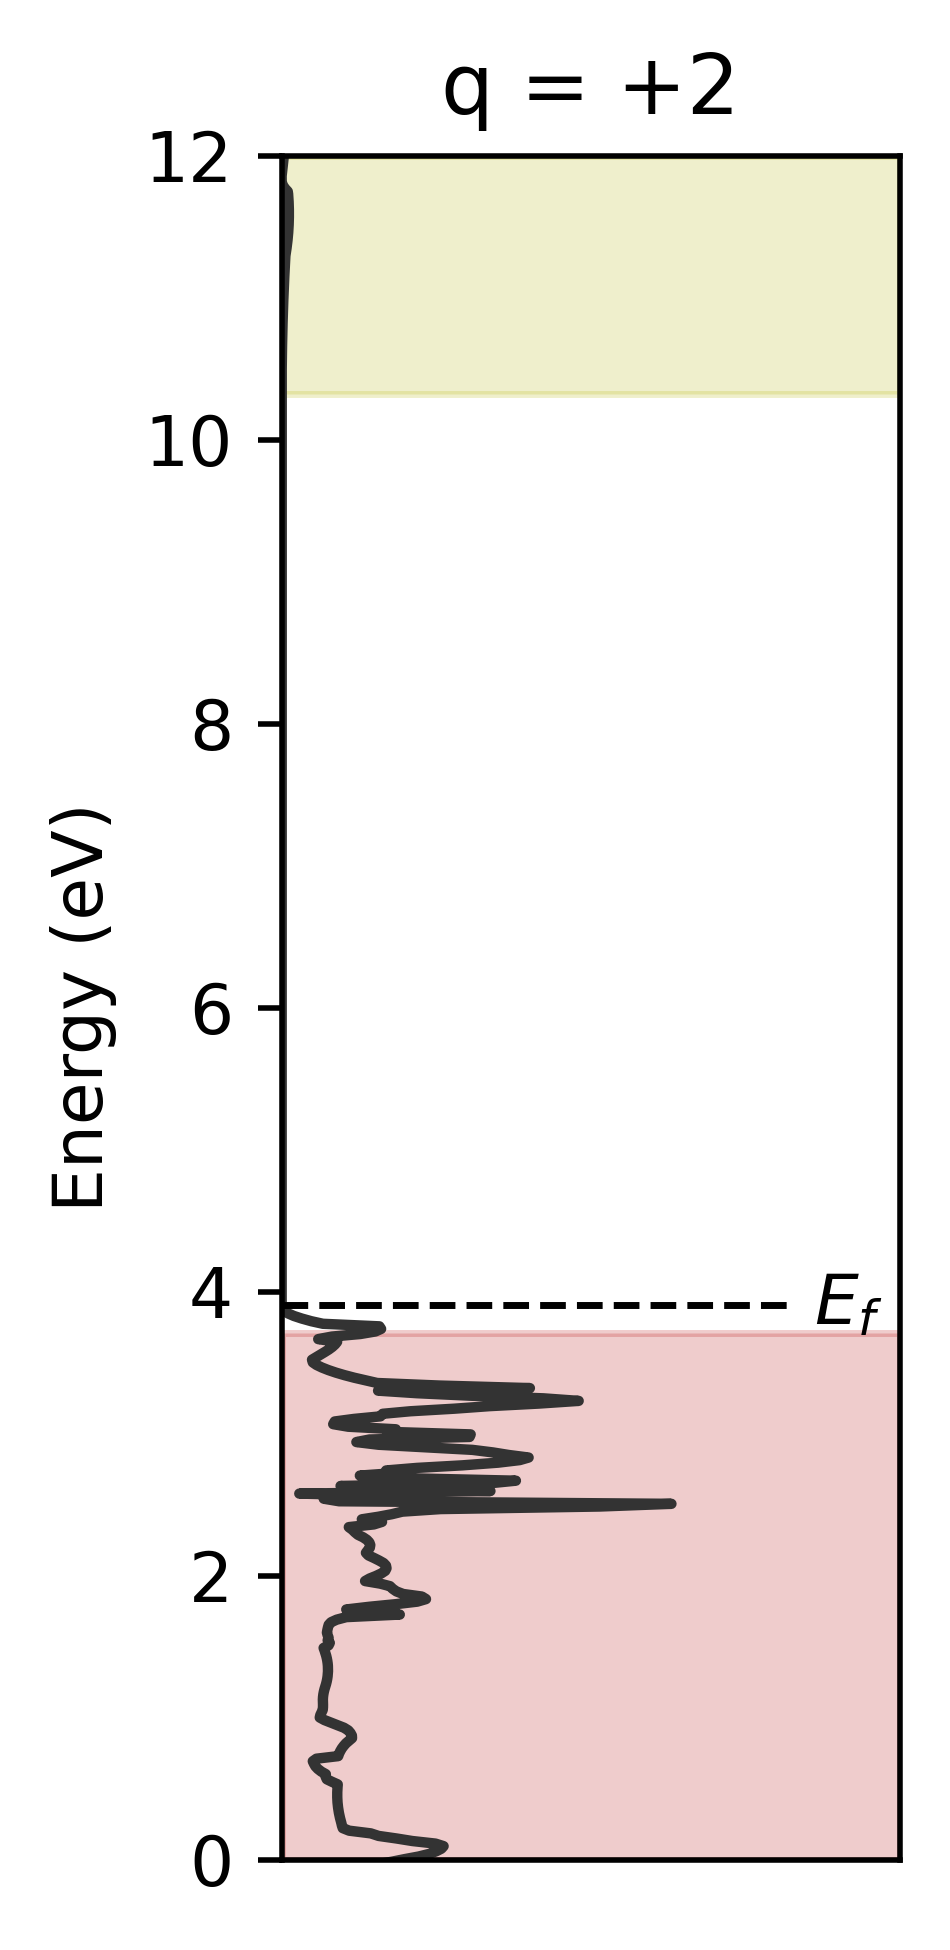

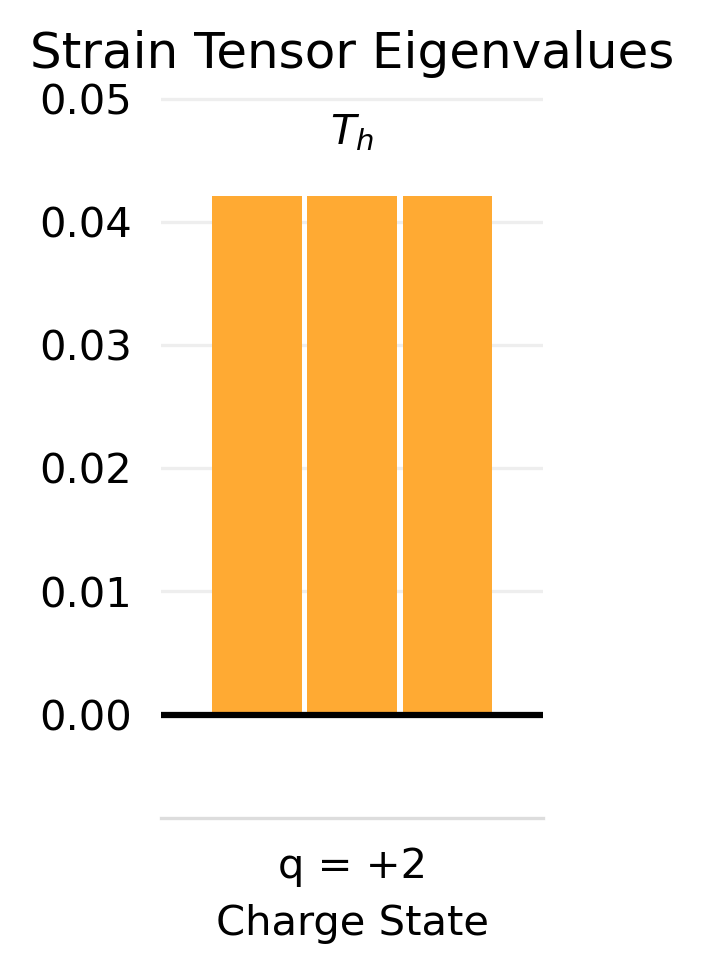

In [166]:
#Density of States Plots
base = "../DFT_Data/Sym/Magnesium_Interstitial/"
address_list = [ "q+2"] 
savename = "Mg_Interstitial_DOS.pdf"
label_list = [ "q = +2"]
fermi_level_data = pd.read_csv(base+"Mg_Interstitial_Energy.txt", delim_whitespace=True)
fermi_level_list = list(fermi_level_data["Fermi_Level"][[4]])
doscar_plot(base+"DOS/", address_list, savename, label_list, fermi_level_list)

#Atomic Positions
reference = pd.read_csv("../DFT_Data/Sym/Magnesium_Interstitial/POS/reference", delim_whitespace=True)
qplus2_pos = pd.read_csv("../DFT_Data/Sym/Magnesium_Interstitial/POS/q+2", delim_whitespace=True)

defect_pos = lattice_constant*np.array([0.375, 0.375, 0.375])
defect_index = np.argwhere((np.array(reference["X"])==0.375)*(np.array(reference["Y"])==0.375)*(np.array(reference["Z"])==0.375))[0][0]
pos_list = [qplus2_pos]
ref_pos = (lattice_constant*np.array(reference["X"]), 
           lattice_constant*np.array(reference["Y"]), 
           lattice_constant*np.array(reference["Z"]))

nn_indices = nearest_neighbor_indices(defect_pos, ref_pos)
strain_eigenvalues = []
pg_list = []
for i, pos in enumerate(pos_list):
    
    
    
    atomic_pos = (lattice_constant*np.array(pos["X"]), 
                  lattice_constant*np.array(pos["Y"]), 
                  lattice_constant*np.array(pos["Z"]))
    
    #print(label_list[i])
    #displacement_plot(atomic_pos, ref_pos, 33, 32, arrow_length=1)

    strain_tensor = generate_strain_tensor(defect_pos, atomic_pos, ref_pos)
    eigvals = np.linalg.eigvals(strain_tensor)
    strain_eigenvalues += list(eigvals)
    

    pg_list.append(point_group((x, y, z), real_defect_pos))

strain_tensor_bar(strain_eigenvalues, label_list, pg_list, "Mg_Intersitial")

<h3>Magnesium Vacancy</h3>

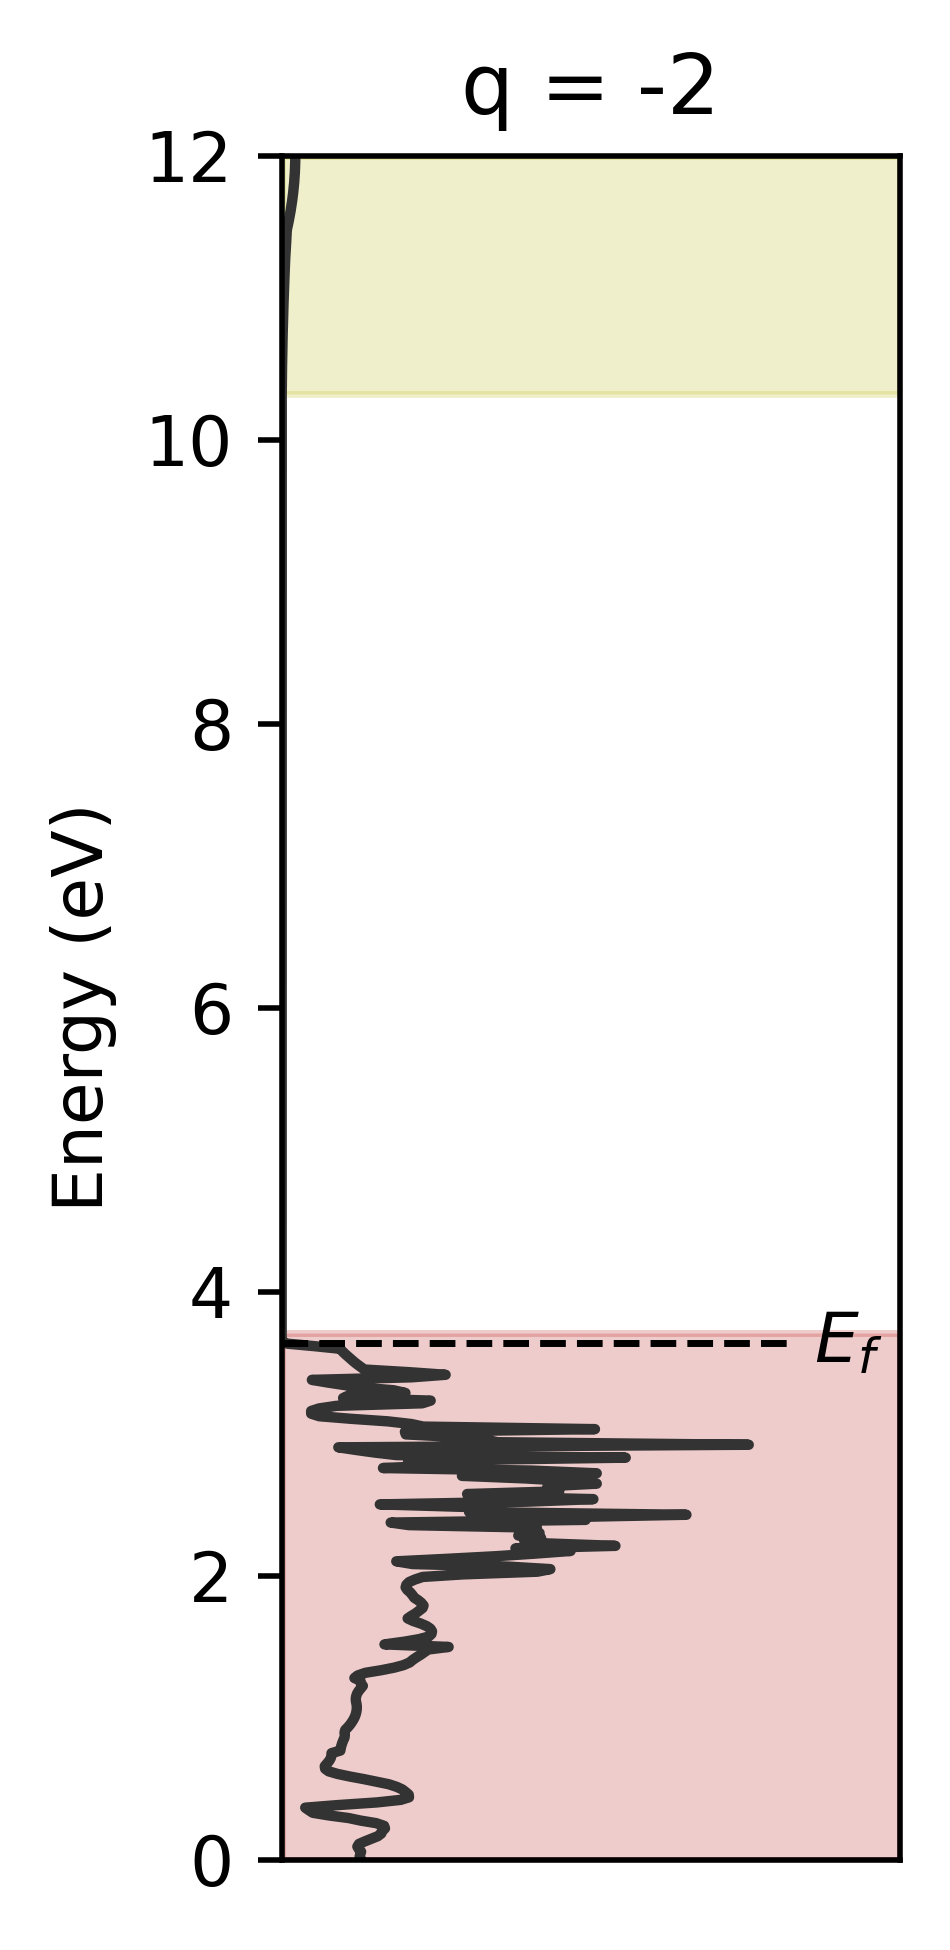

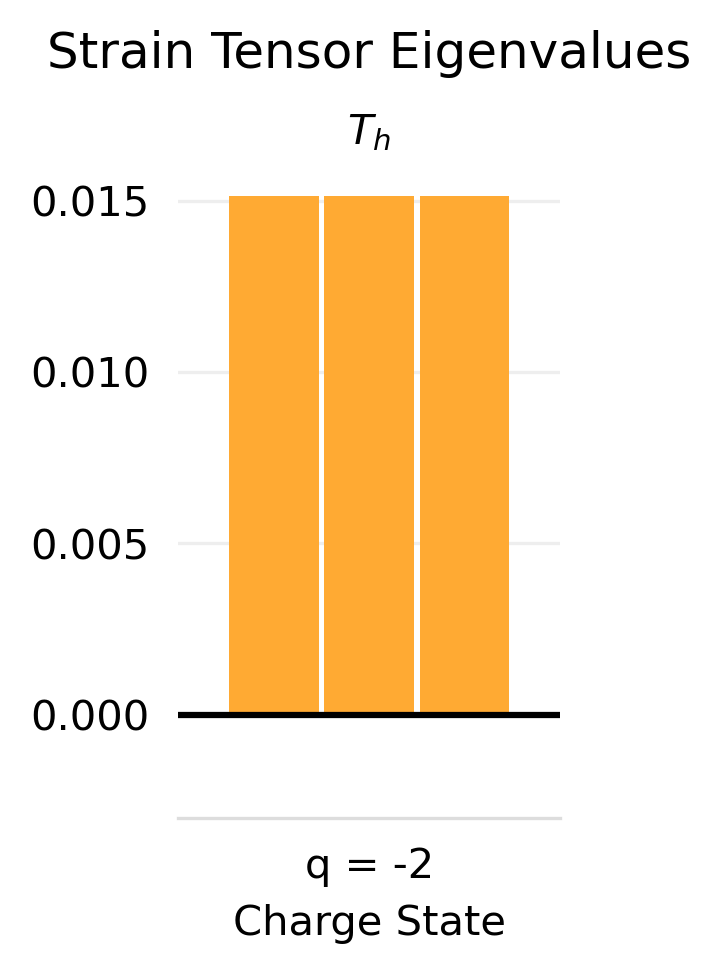

In [167]:
#Density of States Plots
base = "../DFT_Data/Sym/Magnesium_Vacancy/"
address_list = [ "q-2"] 
savename = "Mg_Vacancy_DOS.pdf"
label_list = [ "q = -2"]
fermi_level_data = pd.read_csv(base+"Mg_Vacancy_Energy.txt", delim_whitespace=True)
fermi_level_list = list(fermi_level_data["Fermi_Level"][[2]])
doscar_plot(base+"DOS/", address_list, savename, label_list, fermi_level_list)

#Atomic Positions
reference = pd.read_csv("../DFT_Data/Sym/Magnesium_Vacancy/POS/reference", delim_whitespace=True)
qplus2_pos = pd.read_csv("../DFT_Data/Sym/Magnesium_Vacancy/POS/q+2", delim_whitespace=True)

defect_pos = lattice_constant*np.array([0.5, 0.5, 0.5])
pos_list = [qplus2_pos]
ref_pos = (lattice_constant*np.array(reference["X"]), 
           lattice_constant*np.array(reference["Y"]), 
           lattice_constant*np.array(reference["Z"]))

nn_indices = nearest_neighbor_indices(defect_pos, ref_pos)
strain_eigenvalues = []
pg_list = []
for i, pos in enumerate(pos_list):
    
    atomic_pos = (lattice_constant*np.array(pos["X"]), 
                  lattice_constant*np.array(pos["Y"]), 
                  lattice_constant*np.array(pos["Z"]))
    
    #print(label_list[i])
    #displacement_plot(atomic_pos, ref_pos, 31, 32, arrow_length=1)

    strain_tensor = generate_strain_tensor(defect_pos, atomic_pos, ref_pos)
    eigvals = np.linalg.eigvals(strain_tensor)
    strain_eigenvalues += list(eigvals)
    
    pg_list.append(point_group((x, y, z), real_defect_pos))

strain_tensor_bar(strain_eigenvalues, label_list, pg_list, "Mg_Vacancy")